In [3]:
pip install catboost

     |████████████████████████████████| 76.3 MB 1.2 MB/s 


In [4]:
pip install optuna

     |████████████████████████████████| 308 kB 5.2 MB/s 
     |████████████████████████████████| 80 kB 8.9 MB/s 
     |████████████████████████████████| 209 kB 66.7 MB/s 
     |████████████████████████████████| 75 kB 3.8 MB/s 
     |████████████████████████████████| 49 kB 5.5 MB/s 
     |████████████████████████████████| 112 kB 68.8 MB/s 
     |████████████████████████████████| 149 kB 66.5 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=5c608c8b6a51c70e71c5f08b68d07fe2fc626eb0f63a6d86ffb3e49932ee104d
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [5]:
pip install shap

     |████████████████████████████████| 564 kB 5.1 MB/s 


In [6]:
import os
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly

import catboost as cb
import optuna
from optuna.samplers import TPESampler
optuna.logging.set_verbosity(optuna.logging.WARNING)

import shap

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import mean_absolute_error, accuracy_score, roc_auc_score, f1_score, fbeta_score, roc_curve, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from yellowbrick.classifier import ROCAUC
from yellowbrick.contrib.wrapper import wrap


In [7]:
# seed everything

my_seed = 42

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

seed_everything(my_seed)

In [8]:

file = 'student-grades.csv'

In [9]:
df = pd.read_csv(file)

df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,6,10,10


In [10]:
df.shape

(395, 33)

In [11]:
df.isnull().values.any()

False

In [12]:
df.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000
mean,16.696203,2.749367,2.521519,1.448101,2.035443,0.334177,3.944304,3.235443,3.108861,1.481013,2.291139,3.554430,5.708861,10.908861,10.713924,10.415190
std,1.276043,1.094735,1.088201,0.697505,0.839240,0.743651,0.896659,0.998862,1.113278,0.890741,1.287897,1.390303,8.003096,3.319195,3.761505,4.581443
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,8.000000,9.000000,8.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,4.000000,11.000000,11.000000,11.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,8.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,19.000000,19.000000,20.000000


In [13]:
df.describe(include=[object])

,school,sex,address,famsize,Pstatus,Mjob,Fjob,reason,guardian,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic
count,395,395,395,395,395,395,395,395,395,395,395,395,395,395,395,395,395
unique,2,2,2,2,2,5,5,4,3,2,2,2,2,2,2,2,2
top,GP,F,U,GT3,T,other,other,course,mother,no,yes,no,yes,yes,yes,yes,no
freq,349,208,307,281,354,141,217,145,273,344,242,214,201,314,375,329,263


# Feature Engineering

In [14]:
# create pass and fail column

df['pass'] = np.where(df['G3'] >= 10, 'pass', 'fail')

In [15]:
# create letter grade column

df.loc[df['G3'] < 10, 'Grade'] = 'F'
df.loc[(df['G3'] >= 10) & (df['G3'] <= 11), 'Grade'] = 'D'
df.loc[(df['G3'] >= 12) & (df['G3'] <= 13), 'Grade'] = 'C'
df.loc[(df['G3'] >= 14) & (df['G3'] <= 15), 'Grade'] = 'B'
df.loc[df['G3'] >= 16, 'Grade'] = 'A'

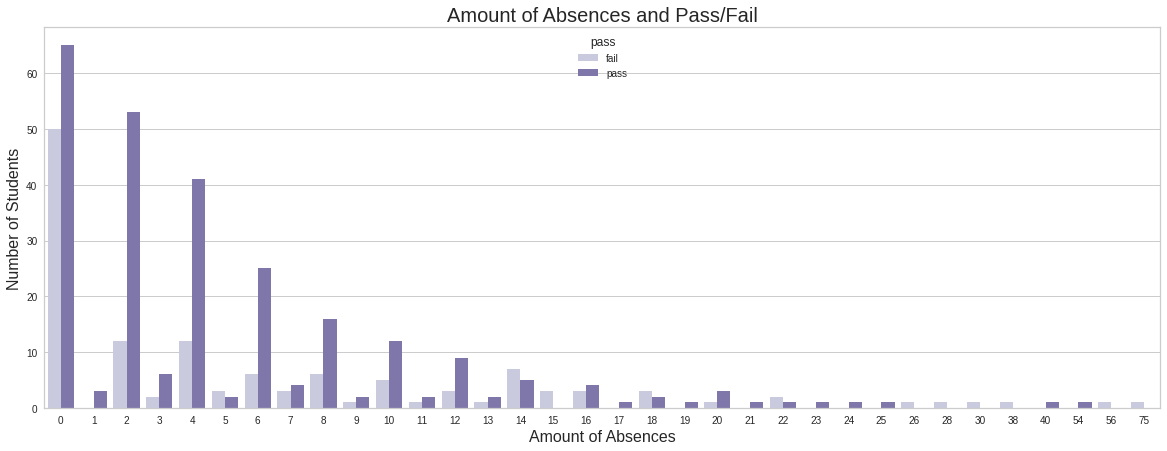

In [16]:
# plot absences vs pass/fail

fig = plt.figure(figsize=(20, 7))

study = sns.countplot(data=df, x="absences", hue="pass", palette='Purples')

plt.title('Amount of Absences and Pass/Fail', fontsize=20)
plt.xlabel('Amount of Absences', fontsize=16)
plt.ylabel('Number of Students', fontsize=16)

plt.show()

In [17]:
# binning the days

df['absences'] = df['absences'].replace([1, 3, 5, 7, 9, 11 ,13, 15, 17, 19, 21, 23, 25],
                       [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26])

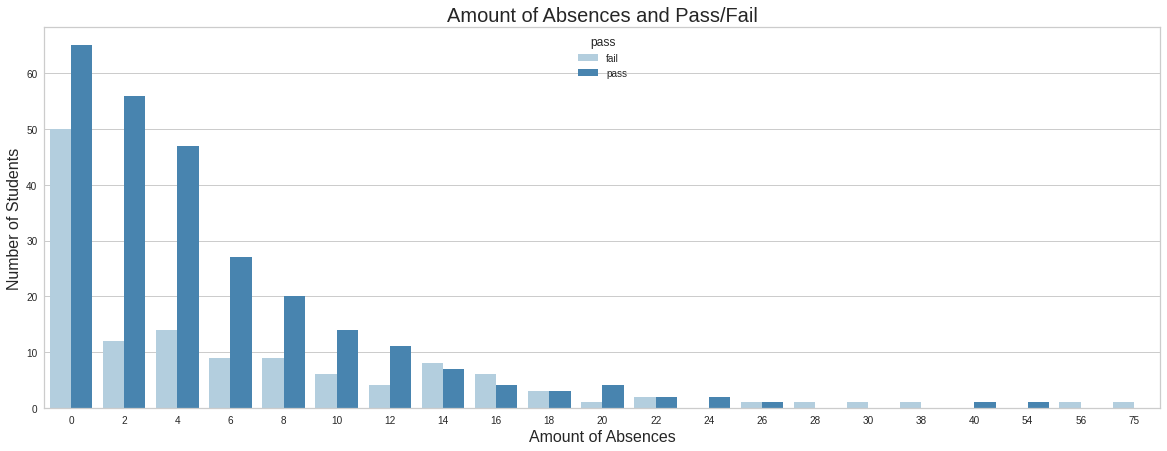

In [18]:
# plot absences vs pass/fail

fig = plt.figure(figsize=(20, 7))

study = sns.countplot(data=df, x="absences", hue="pass", palette='Blues')

plt.title('Amount of Absences and Pass/Fail', fontsize=20)
plt.xlabel('Amount of Absences', fontsize=16)
plt.ylabel('Number of Students', fontsize=16)

plt.show()

In [19]:
# manually encoding pass column

fmap = {'pass':1, 'fail':0}

# apply filter to pass column

df['pass'] = df['pass'].map(fmap)

In [ ]:
df.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3', 'pass', 'Grade'],
      dtype='object')

In [ ]:
categorical_features_indices = [0, 1, 3, 4, 5, 8, 9, 10, 11, 15, 16, 17, 18, 19, 20 ,21, 22]

# 1) Regression Modeling (Number Grade)

## A) Baseline Modeling After the Second Trimester (G1, G2) for Final Grade (G3)

In [ ]:
train_df , test_df = train_test_split(df, test_size=0.2, random_state=my_seed, stratify=df['Grade'])

In [ ]:
features = ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
           'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
           'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
           'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
           'Walc', 'health', 'absences', 'G1', 'G2']
target = ['G3']

In [ ]:
train_features = train_df[features]
train_target = train_df[target]

test_features = test_df[features]
test_target = test_df[target]

In [ ]:
def objective(trial):

    params = {
                     "loss_function": trial.suggest_categorical("loss_function", ["RMSE", "MAE"]),
                     'od_wait': trial.suggest_int('od_wait', 10, 50, step=1),
                     "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.99),
                     "random_strength": trial.suggest_int("random_strength", 1, 10, step=1),
                     "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 50.0),
                     "max_depth": trial.suggest_int("max_depth", 2, 10, step=1),
                     "n_estimators": trial.suggest_int("n_estimators", 100, 3000, step=1),
                     'learning_rate': trial.suggest_loguniform("learning_rate", 0.005, 0.1),
                     "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 60),
                    "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
                    "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
                    "one_hot_max_size": trial.suggest_int("one_hot_max_size", 2, 10),
                    }

    # Conditional Hyper-Parameters
    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.5, 0.99)
    elif params["bootstrap_type"] == "MVS":
        params["subsample"] = trial.suggest_float("subsample", 0.5, 0.99)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=my_seed)

    cv_scores = []

    for train_index, test_index in skf.split(train_features,train_target):

        train_x, valid_x = train_features.iloc[train_index], train_features.iloc[test_index]
        train_y, valid_y = train_target.iloc[train_index], train_target.iloc[test_index]  

        train_pool = cb.Pool(train_x, train_y, cat_features=categorical_features_indices)
        valid_pool = cb.Pool(valid_x, valid_y, cat_features=categorical_features_indices)

        cb_reg_model = cb.CatBoostRegressor(**params, random_state=my_seed)

        cb_reg_optuna = cb_reg_model.fit(train_pool, eval_set=valid_pool, verbose=False, 
                                         early_stopping_rounds=100, use_best_model=True)

        preds = cb_reg_optuna.predict(valid_x)

        MAE = mean_absolute_error(valid_y, preds)

        cv_scores.append(MAE)

    cv_avg_score = np.mean(cv_scores)    

    print('Avg MAE score of CV CatBoost Regression=', cv_avg_score)

    return cv_avg_score

In [ ]:
study = optuna.create_study(direction="minimize", sampler = TPESampler(seed=my_seed), study_name="Trimester 2 Regression")
study.optimize(objective, n_trials=300, n_jobs=-1)

`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
The least populated class in y has only 1 members, which is less than n_splits=5.
The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.3895571323172813


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.2226697419946735


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.2519751970152575


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.580138142227471


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.2263767469775098


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.9201439785696137


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.108671190658582


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.4791950911761016


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.2049821726483252


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 2.0311834316183144


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1068261735967997


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.121560998026615


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.2123115991075462


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1239709919132195


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.2150024742449124


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.3068795159876436


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0981934483414282


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1513116917348996


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.288771669837039


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.8589915847941794


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.3295502848636336


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1386420453918775


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1108834918195527


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1432728764970315


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1072079952640383


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1495634233693175


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.171413101636186


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.607750175092867


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5031163629683788


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.3580854956980168


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.2542760822022068


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1102948968203286


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1157424988827978


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1824142907324382


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.2306089352477723


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0856235044694702


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.2438739258500404
Avg MAE score of CV CatBoost Regression= 1.092810533973473


The least populated class in y has only 1 members, which is less than n_splits=5.
The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.161560668701941
Avg MAE score of CV CatBoost Regression= 1.0991216169981919


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1314456291056358


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1670516568797427


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1012965011218465


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1194923035720468
Avg MAE score of CV CatBoost Regression= 1.1265042809295494


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.109725918737253
Avg MAE score of CV CatBoost Regression= 1.1507908520319643


The least populated class in y has only 1 members, which is less than n_splits=5.
The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.2497434537384735


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.235887145533186


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1212958251699823


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.35891279044363


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.124357937386168


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0999402811334538


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1482963570395899


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.115550249512361


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.4653416811857245


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.2081063661805966


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.3639401147902424


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.2308322782762315


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1134996798558636


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1176511379577794


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0884893204047128


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0970529954918053


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0908261541431095


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0758261370163356


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0822513284405844


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1166909015819877


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1323651408784998


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1174122981234944


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.347722994806285


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0796155577908846


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0865108731303619


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0907291602367535


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0801254162723528


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.256696881122764


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1186626571127973


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0913787124220988


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1178409598390069


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 2.0187124791035798


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.138432973272669


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.092994422006024


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.083099058959944


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.084413176741885


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.071494350326855


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0723041213817717


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0782895457826096


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1000141141679523


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1094832832080883


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.189099329185338


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1989616375972365


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1378262826285621


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0665588299351225


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1519564793981543


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.079703312337441


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.0803070947954965


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0735307707249173


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1062063587671758


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.072981734752123


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1036424302475225


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0763018305653422


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.092014756474011


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.0925480401718608


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1130189138907336


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0890271018289341


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1167157627107445


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0912767000202224
Avg MAE score of CV CatBoost Regression= 1.0849335235827249


The least populated class in y has only 1 members, which is less than n_splits=5.
The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.1330397770792484


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1883613873893077


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.090605385585317


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.083985924077815


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0665945280824767


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.081594007388867


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.327522960583962


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.141755004756772


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.072739116052886


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0998483192338313
Avg MAE score of CV CatBoost Regression= 1.0767993626756795


The least populated class in y has only 1 members, which is less than n_splits=5.
The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.0741155360381243


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.090761275209956


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0886605660908253


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0663534625628934


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0681647575052267


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0665607483610668


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0817846175706767


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0717432398841982


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0745377602077746


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.3744727549384987


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.2804590793382318


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0850232974749132


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.07403351999011


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.4903879527881987


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.146974788226117


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0738863374246728


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.103981216294083


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0808240707673988


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0724765625686807


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0738541424244372


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0734719066121756


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.078163236722955


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0783090314898116


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1091791972401048


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.0701687289239343


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.2075565279741713


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.130130005877135


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1033418650103577
Avg MAE score of CV CatBoost Regression= 1.0958464636721694


The least populated class in y has only 1 members, which is less than n_splits=5.
The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.1160774088084033


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1207302617979886


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0699241254299832


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1727504854153539


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.089971919399177


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1266950879216295


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.080364122745691


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.10142934579552


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0926184928847031


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.0703343027524284


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.075616104590208


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0761737478215019


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.2306968594918453


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1990021598253642


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0922873471283086


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.0648372594372866


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0948591700191748


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0824505697086548


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0660911060733518


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.0679337585039266


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.076309639787402


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0758061354579613


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0844699826565503


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0731272700679033
Avg MAE score of CV CatBoost Regression= 1.0754693572994107


The least populated class in y has only 1 members, which is less than n_splits=5.
The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.0634477846068642


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0772471502565053


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0705962868598078


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0978513392893814


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0790006260927463


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0682756355289251


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.245673152312126


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.101746575895353
Avg MAE score of CV CatBoost Regression= 1.0763815261269323


The least populated class in y has only 1 members, which is less than n_splits=5.
The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.0838813968270231


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0762475584152618


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.0760847677346774


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0694791866473479


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.0737290740369885


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0872399466799991


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0941644625723306


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0917573618864274


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.0664283270135484


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0822441412893093


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.0674912992760133


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0717715925811984


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0818268905494186


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0609366703000953


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0770081760108592


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.070821414803778


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0987576531518997


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.067613438013634


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0506078876999125


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0872980666776537


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.076666747284916


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0869138991374
Avg MAE score of CV CatBoost Regression= 1.075681207824339


The least populated class in y has only 1 members, which is less than n_splits=5.
The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.073449142215194


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0802902704606514


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.071929399637955


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0822981024556715


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1041951712229132


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1590918831800359


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.138156979094599


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0656712004517246


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1032343217267042


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0658546008099565


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0717718057789045


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0792040383821384


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.0857990993658615


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0601479884686789


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0737012657990488


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0770824769345744


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.390925847108648


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0669721343475373


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0886059021483199


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0696875200325922


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0683184016894687


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0621265962809356


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0737212313367834


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.073111032696295


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.3803553336876724


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0762210720120409


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.0630107322700137


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.058952978211778


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0587023494565406


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0659148970307968


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0608758928856048


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.0760955900807807


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.073141376766833


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0620926909879205


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.067522338875058


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1328329573160238


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.105420301647013


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.124353540650801


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1177589848274632


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0721659516262334


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.175243688514735


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0726600134467534


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0726110973711611


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.0615125220475539


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.078523609296291


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0842339573207513


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.080057732360889


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0638590917967146


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0946079874637724


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0705145967103715


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0803716141356903


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0982456941046013


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0816496378003992
Avg MAE score of CV CatBoost Regression= 1.0650087825381171


The least populated class in y has only 1 members, which is less than n_splits=5.
The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.0705719108507918
Avg MAE score of CV CatBoost Regression= 1.0883721027373212


The least populated class in y has only 1 members, which is less than n_splits=5.
The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.1008806377810685
Avg MAE score of CV CatBoost Regression= 1.0938704266039845


The least populated class in y has only 1 members, which is less than n_splits=5.
The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0708158040813534


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0730807519807353


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0737918452094697


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.10398823195089


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1130492880912233


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.0758825110425234


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1562605593438129


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1816647242214486


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0817709546152268


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0632329800307676


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0605871667144986


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0537400997387774


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0871985950590708


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.2616569770715942


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.059401667505187


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0805221144960242


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.091734562511419


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0704624956420548


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.3194880990541946


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.1026725265781754


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.266857079476574


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0666704738756176


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.1043101544040415
Avg MAE score of CV CatBoost Regression= 1.0747834078309273


The least populated class in y has only 1 members, which is less than n_splits=5.
The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.0703692265626592


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0931701843413297


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.07280380302926


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0710241612192728


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1715173464219815


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1011610223383221


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.081779100807912


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0681185396362338


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0738669758307098


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.085089658010811


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0874044423480915


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1027671964932622


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.06727949297624
Avg MAE score of CV CatBoost Regression= 1.0628660772169183


In [ ]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 300
Best trial:
  Value: 1.0506078876999125
  Params: 
    loss_function: MAE
    od_wait: 25
    colsample_bylevel: 0.8978493577542801
    random_strength: 1
    l2_leaf_reg: 32.911283310459936
    max_depth: 2
    n_estimators: 2729
    learning_rate: 0.03284644036586862
    min_data_in_leaf: 60
    boosting_type: Plain
    bootstrap_type: Bernoulli
    one_hot_max_size: 2
    subsample: 0.7708370135569105


In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:

optuna.visualization.plot_param_importances(study)

In [ ]:
optuna.visualization.plot_slice(study, params=['colsample_bylevel','max_depth', 'learning_rate' ,'random_strength', 'n_estimators'])

In [ ]:
best_model = cb.CatBoostRegressor()
best_model = best_model.set_params(**study.best_params)
best_model = best_model.fit(train_features, train_target, cat_features= categorical_features_indices, 
                            verbose=False, early_stopping_rounds=100)

preds = best_model.predict(test_features)

MAE = mean_absolute_error(test_target, preds)

print('MAE score of CatBoost =', MAE)

MAE score of CatBoost = 0.8621298931819636


In [ ]:
feature_importance_df = pd.DataFrame(best_model.get_feature_importance(prettified=True))
feature_importance_df

,Feature Id,Importances
0,G2,70.999225
1,G1,13.069393
2,absences,4.492813
3,Mjob,1.580549
4,failures,1.279340
5,age,1.221229
6,guardian,1.070621
7,Medu,0.884888
8,Fjob,0.868222
9,famrel,0.721381


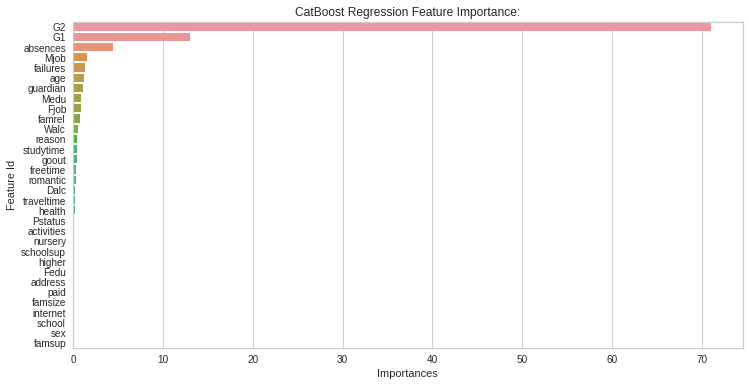

In [ ]:
plt.figure(figsize=(12, 6));
sns.barplot(x="Importances", y="Feature Id", data=feature_importance_df);
plt.title('CatBoost Regression Feature Importance:');

In [ ]:
shap_pool = cb.Pool(train_features, train_target, cat_features=categorical_features_indices)

shap_values = best_model.get_feature_importance(shap_pool, type='ShapValues')
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]
print(shap_values.shape)

(316, 32)


In [ ]:
shap.initjs()
shap.force_plot(expected_value, shap_values[3,:], train_features.iloc[3,:])

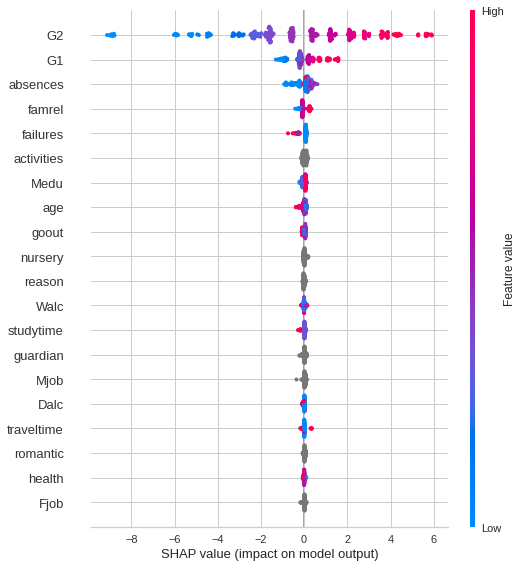

In [ ]:
shap.summary_plot(shap_values, train_features)

In [ ]:
shap.initjs()
x_small = train_features.iloc[0:200]
shap_small = shap_values[:200]
shap.force_plot(expected_value, shap_small, x_small)

## B) Modeling After the Second Trimester (G1, G2) for Final Grade (G3)

In [28]:
to_drop = ['higher', 'Fedu', 'address', 'paid', 'famsize', 'internet', 'sex', 'famsup']

feature_df = df.drop(columns = to_drop, axis = 'columns', inplace = False)

In [29]:
feature_df.columns

Index(['school', 'age', 'Pstatus', 'Medu', 'Mjob', 'Fjob', 'reason',
       'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup',
       'activities', 'nursery', 'romantic', 'famrel', 'freetime', 'goout',
       'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3', 'pass',
       'Grade'],
      dtype='object')

In [30]:
train_df , test_df = train_test_split(feature_df, test_size=0.2, random_state=my_seed, stratify=df['Grade'])

In [46]:
features = ['absences','Mjob','failures','age','guardian','Medu','Fjob','famrel','Walc',
            'reason','studytime','goout','freetime','romantic','Dalc','traveltime','health','Pstatus',
            'activities','nursery','schoolsup','G1','G2']
target = ['G3']

In [48]:
train_features = train_df[features]
train_target = train_df[target]

test_features = test_df[features]
test_target = test_df[target]

In [49]:
train_features


,absences,Mjob,failures,age,guardian,Medu,Fjob,famrel,Walc,reason,studytime,goout,freetime,romantic,Dalc,traveltime,health,Pstatus,activities,nursery,schoolsup,G1,G2
70,0,other,0,16,father,3,other,4,1,reputation,4,2,3,no,1,2,5,T,no,yes,no,13,15
355,0,services,0,18,father,3,services,5,1,course,2,4,3,yes,1,1,5,T,no,yes,no,10,9
48,2,teacher,0,15,mother,4,other,4,2,home,2,3,3,no,2,1,5,T,no,yes,no,15,15
22,2,teacher,0,16,mother,4,other,4,3,course,2,1,5,no,1,1,5,T,yes,yes,no,15,15
112,6,at_home,1,16,mother,2,other,3,1,home,2,2,1,no,1,1,5,T,yes,yes,yes,10,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46,12,other,0,16,mother,3,services,2,4,home,2,5,3,no,1,1,3,A,no,yes,no,11,12
278,16,health,1,18,father,4,health,2,1,reputation,2,4,4,yes,1,1,4,T,yes,yes,yes,9,8
306,0,services,0,20,other,3,other,5,1,course,1,3,5,no,1,1,5,A,yes,yes,no,17,18
126,0,other,0,15,mother,3,other,5,1,home,2,2,3,yes,1,1,1,A,yes,yes,yes,7,10


In [50]:
train_features.columns

Index(['absences', 'Mjob', 'failures', 'age', 'guardian', 'Medu', 'Fjob',
       'famrel', 'Walc', 'reason', 'studytime', 'goout', 'freetime',
       'romantic', 'Dalc', 'traveltime', 'health', 'Pstatus', 'activities',
       'nursery', 'schoolsup', 'G1', 'G2'],
      dtype='object')

In [51]:
categorical_features_indices = [1, 4, 6, 9, 13, 17, 18, 19, 20]

In [36]:
def objective(trial):

    params = {
                     "loss_function": trial.suggest_categorical("loss_function", ["RMSE", "MAE"]),
                     'od_wait': trial.suggest_int('od_wait', 10, 50, step=1),
                     "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.99),
                     "random_strength": trial.suggest_int("random_strength", 1, 10, step=1),
                     "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 50.0),
                     "max_depth": trial.suggest_int("max_depth", 2, 10, step=1),
                     "n_estimators": trial.suggest_int("n_estimators", 100, 3000, step=1),
                     'learning_rate': trial.suggest_loguniform("learning_rate", 0.005, 0.1),
                     "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 60),
                    "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
                    "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
                    "one_hot_max_size": trial.suggest_int("one_hot_max_size", 2, 10),
                    }

    # Conditional Hyper-Parameters
    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.5, 0.99)
    elif params["bootstrap_type"] == "MVS":
        params["subsample"] = trial.suggest_float("subsample", 0.5, 0.99)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=my_seed)

    cv_scores = []

    for train_index, test_index in skf.split(train_features,train_target):

        train_x, valid_x = train_features.iloc[train_index], train_features.iloc[test_index]
        train_y, valid_y = train_target.iloc[train_index], train_target.iloc[test_index]  

        train_pool = cb.Pool(train_x, train_y, cat_features=categorical_features_indices)
        valid_pool = cb.Pool(valid_x, valid_y, cat_features=categorical_features_indices)

        cb_reg_model = cb.CatBoostRegressor(**params, random_state=my_seed)

        cb_reg_optuna = cb_reg_model.fit(train_pool, eval_set=valid_pool, verbose=False, 
                                         early_stopping_rounds=100, use_best_model=True)

        preds = cb_reg_optuna.predict(valid_x)

        MAE = mean_absolute_error(valid_y, preds)

        cv_scores.append(MAE)

    cv_avg_score = np.mean(cv_scores)    

    print('Avg MAE score of CV CatBoost Regression=', cv_avg_score)

    return cv_avg_score

In [37]:
study = optuna.create_study(direction="minimize", sampler = TPESampler(seed=my_seed), study_name="Trimester 2 Regression Features")
study.optimize(objective, n_trials=300, n_jobs=-1)

`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.3548041716398804
Avg MAE score of CV CatBoost Regression= 1.2554776675775012


The least populated class in y has only 1 members, which is less than n_splits=5.
The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5935794477734286


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.2408745783828743


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.1935564672342966


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.4057281039500429


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.561353442395618


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.7549174665421539


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.2371901442979418


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.4355248574813948


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1402598931662242


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.132335788621217


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1600465984276536


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1255514974166605


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1327637345174595


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1624508931916704


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5894298484284566


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.2450326780990197


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.2166955281991667


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1877516800384305


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1777360630230167


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.1251434749717901


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1720861633141675


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.2439270875346744


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.166188350823472


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1008621916705876


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.172833193937685


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.152236198930882


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.175935083417147


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.2417624394384053


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1159996490525146


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1376084690075035


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1184661418463115


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1526059122656611


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.119377371174025
Avg MAE score of CV CatBoost Regression= 1.1921377019260482


The least populated class in y has only 1 members, which is less than n_splits=5.
The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1284654276094144


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1602472127047267


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1411961852328734


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.2254776167844663


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.3393521764279614


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0964238560880144


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1943985491291622


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.4029411690992526


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.15259106183942


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1667568832485609


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.439697441558281


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1049366051666127


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0974239406207338


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.097707940683355


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1679012454757345


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1078622375289706


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.4435490757752198


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.120390107750504


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0989815718871057


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 2.377035242501983
Avg MAE score of CV CatBoost Regression= 1.1182176771063694


The least populated class in y has only 1 members, which is less than n_splits=5.
The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.106474617663143


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.2061093142478554


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1370892552493135


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.4985558908918235


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1166291944555413


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0987698080378787


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.3936688482859938


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1105766621457218


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1064266336219066


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.10968503253104


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1166549872618523


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0786353514395919


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.4271796042531428


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.12192969608247


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1068657242058144


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0977463917101087


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.099796828294204


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.0578591720535742


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1203046685782327


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0755193851944642
Avg MAE score of CV CatBoost Regression= 1.0904153866320492


The least populated class in y has only 1 members, which is less than n_splits=5.
The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.0869817925477192


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.2080109158282297


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1005433794092272


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1273166239601322


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.106591903127387


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0849936901455826


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1098684946673694


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1378953039797568


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0787525150839528


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.101805723105214


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0989938304412672


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0770873103035417


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0723050982187075


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.080007494108685


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.0655354814019098


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0808921020763689


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0629496587181986


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0901321520690643


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.092266921524969


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0764005155379865


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1339663613505349


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1019986119413834


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.106062419663127


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.133357589981484


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0630310723805816


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0686649016974257


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0555534631589045


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0767474294688522


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1360226706659136


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.136512142816761


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0763884967684563


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0855891701082148


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1007176254255842


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1523325829622224


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0844644832854125


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0668729757464754


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.07172012118563


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0695389977842413


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0933832319841281


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0649603009265864


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0671836966853205


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.051903486800215


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.085968024577947


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0661862479441822


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.077101830796367


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0627414050440074


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0913685333946925


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.0777422977290274


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0981991554008599


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1140309038614684


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1021368607169248


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1385702116028287


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1472008828860971


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.058244836920844


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.076603209048437


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.0819358793316924


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0704450026577348


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0878927586175806


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1452291100605838


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.14021136287829


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0842162825934558


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.191619826613067


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1004997446511173


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1177715719348418


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1253857462336585


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1215596317297496


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0869331695312823


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.0877764389750215


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.0758865604501187


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.059426978248662


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0656089906287518


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 2.021981052664657


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.1777076030931966


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1025758516135673


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0594787195465467


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.0550591039806534


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.0825231717711232
Avg MAE score of CV CatBoost Regression= 1.0782532006916032


The least populated class in y has only 1 members, which is less than n_splits=5.
The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0845935715473678


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0595825377959582


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.111438675091612


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1167501402244437


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0898546091231154


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.082220412862603


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0654717114492964


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0771846749446325


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0710881844089006


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0748561053218846


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.082540091712876


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0673991207555062


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0619172046521632


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0836479576335738


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0748307143748905


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.070817163449898


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0755684858601815


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0913970105531188


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0667713542311783


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0813834329619367


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0775679578806308


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0795059331883252


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1096829100459402


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.0668928434010527


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0685710018755352


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0884889089781928


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0660891108682522


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0723862508886883


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.126952870826275


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.087244038208906


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0635837188136499


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0727749611319741


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1692644762665754


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1318114471996281


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0763384376869276


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1021059425226856


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0550365957926477


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0731453314192843


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1276477983329218


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0980399998897936


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1188284708248815


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0720130852235534


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.0541418332123471


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0564078894657283


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0809353341796313


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.103902465496164


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.084873921259349


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0909882551216208


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0555480834542716


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0935487193426148


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0604436125955499


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0719319132899812
Avg MAE score of CV CatBoost Regression= 1.0934073451681097


The least populated class in y has only 1 members, which is less than n_splits=5.
The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.08625773885016


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0860044150688364


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.2408576600343815


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0875463643039478


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.067672801133669


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.091947666718077


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.096826534288234


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0914929107487812


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0701797085804654


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0727573511103394


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.167325497379751


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0582139975236344


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0937963008966656


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.059642193808989


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0700538398864956


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.0660518854896974


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0613477782504739


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0680099444756155


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0660731394197636


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0999801586739493


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0605973712301153


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0582314155946093


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.096752389100248


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0858818839183937


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.050237881093252


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0614619446515547


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.054769655622787


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0571584378903995


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0666073180942033


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0485442467197994


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0468176054006668


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0705614777671173


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.056252752903999


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.064180328175891


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0631637151880056


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.058467122266061


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0439931838348644


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1405534880997388


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0585716998584764


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0756249323597327


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0740759058586236


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.0602583179668588


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.060124359337442


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0752613304763927


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0471065565543287


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0628759566470123


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0651955951776895


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0761965245175091


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1043457537124115


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0803625109523434


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1209628431298877


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.144567135165911


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.224368620889115


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0711955217134015


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.245759724198961


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.2575502294897998


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.071149831258474


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1150296213295356


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0557243144485307


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0766905907452156


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0687964412775899


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0589062346244107


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0655493629716375


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0797324502039318


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0746786064938219


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.07924250133952


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1118327186387533


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0820658634232978


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0731501364200335


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0685238431264121


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0958333869325616


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0687527833295665


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1144287334447545


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.082729466831213


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.064415983268741


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0756574097359148


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0719169613762325


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0732885840007618


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1257075961881142


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1292064618719906


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1605333275109033


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.062879669349209


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.078912888213905


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0581199116722113


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.1128162864805393


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0561105869422884


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0663702971802302


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0539761158691994


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0579809665026718


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.0513668463197314
Avg MAE score of CV CatBoost Regression= 1.150863017232163


In [38]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 300
Best trial:
  Value: 1.0439931838348644
  Params: 
    loss_function: MAE
    od_wait: 11
    colsample_bylevel: 0.9141882630192624
    random_strength: 1
    l2_leaf_reg: 2.2361232219068055
    max_depth: 3
    n_estimators: 2025
    learning_rate: 0.02188950722707121
    min_data_in_leaf: 60
    boosting_type: Ordered
    bootstrap_type: Bernoulli
    one_hot_max_size: 3
    subsample: 0.9513000484727004


In [39]:
best_model = cb.CatBoostRegressor()
best_model = best_model.set_params(**study.best_params)
best_model = best_model.fit(train_features, train_target, cat_features= categorical_features_indices, 
                            verbose=False, early_stopping_rounds=100)

preds = best_model.predict(test_features)

MAE = mean_absolute_error(test_target, preds)

print('MAE score of CatBoost =', MAE)

MAE score of CatBoost = 0.7862128251630773


## B) Modeling After the First Trimester (G1) for Final Grade (G3)

In [52]:
features = ['absences','Mjob','failures','age','guardian','Medu','Fjob','famrel','Walc',
            'reason','studytime','goout','freetime','romantic','Dalc','traveltime','health','Pstatus',
            'activities','nursery','schoolsup','G1',]
target = ['G3']

In [53]:
train_features = train_df[features]
train_target = train_df[target]

test_features = test_df[features]
test_target = test_df[target]

In [54]:
def objective(trial):

    params = {
                     "loss_function": trial.suggest_categorical("loss_function", ["RMSE", "MAE"]),
                     'od_wait': trial.suggest_int('od_wait', 10, 50, step=1),
                     "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.99),
                     "random_strength": trial.suggest_int("random_strength", 1, 10, step=1),
                     "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 50.0),
                     "max_depth": trial.suggest_int("max_depth", 2, 10, step=1),
                     "n_estimators": trial.suggest_int("n_estimators", 100, 3000, step=1),
                     'learning_rate': trial.suggest_loguniform("learning_rate", 0.005, 0.1),
                     "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 60),
                    "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
                    "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
                    "one_hot_max_size": trial.suggest_int("one_hot_max_size", 2, 10),
                    }

    # Conditional Hyper-Parameters
    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.5, 0.99)
    elif params["bootstrap_type"] == "MVS":
        params["subsample"] = trial.suggest_float("subsample", 0.5, 0.99)


    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=my_seed)

    cv_scores = []

    for train_index, test_index in skf.split(train_features,train_target):

        train_x, valid_x = train_features.iloc[train_index], train_features.iloc[test_index]
        train_y, valid_y = train_target.iloc[train_index], train_target.iloc[test_index]  

        train_pool = cb.Pool(train_x, train_y, cat_features=categorical_features_indices)
        valid_pool = cb.Pool(valid_x, valid_y, cat_features=categorical_features_indices)

        cb_reg_model = cb.CatBoostRegressor(**params, random_state=my_seed)

        cb_reg_optuna = cb_reg_model.fit(train_pool, eval_set=valid_pool, verbose=False, 
                                         early_stopping_rounds=100, use_best_model=True)

        preds = cb_reg_optuna.predict(valid_x)

        MAE = mean_absolute_error(valid_y, preds)

        cv_scores.append(MAE)

    cv_avg_score = np.mean(cv_scores)    

    print('Avg MAE score of CV CatBoost Regression=', cv_avg_score)

    return cv_avg_score

In [55]:
study = optuna.create_study(direction="minimize", sampler = TPESampler(seed=my_seed), study_name="Trimester 1 Regression CV 5")
study.optimize(objective, n_trials=300, n_jobs=-1)

`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 2.0379444299381233


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 2.035420601383794


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.7293722588213192


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.8183599901657987


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.775114871490531


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.9167554889160041


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.652511046321003


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 2.0623702165297617


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 2.4641213403567566


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.8001878651650902


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 2.6435057754001083


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6124327882705471


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.7512768182985083


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.62611117414949


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6261730830310903


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.6214822373552997


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.7698461068142788


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.7126268339640351


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5998121855778253


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6158352936242977


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6197701115612304


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.6480855951231148


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6167926475190033


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6022713214807278


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6084743917773312


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5816128548773407


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.739314884063825


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.608684758375738


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.631520207806504


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6187779736325072


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.7600924245164589


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6423335938092833


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.7805166925504388


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6050644803057643


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6199932902654122


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.7759317100212968


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6159623037122437


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.9808798226581614


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6138396353738034


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.8532763815202855


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.7933673716669483


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6287177732696125


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6013828767125162


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6268317990864716


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6325853417876268


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6078887097462697


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6118639112332986


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6670744081727378


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.600392533274143


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6409028577386593


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 2.3529463782170645


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.8172913680320004


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.713851789131692


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6614361829052853


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6157744879172533


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6210025948669056


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6147924950680175


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6172649194400575


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.7067571913723931


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6560178902500104


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.8694110360197898


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.581056873302138


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.574394497226832


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5764153420987825


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6115722476832932


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6058433964631924


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.582049484747102


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5796675708946868


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6355970789763656


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.578364641458395


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.588962026477982


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6099731494806206


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6066986198773456


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6052980781498274


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5875395203691145


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5815503061679381


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.593893654278


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5884982444998077


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5936437475156076


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.7051680147588713


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.7487590693924582


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5914837290135249


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5856752084582666


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6009050236472873


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.6260992867202986


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6105016360011284


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.604715820024228


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6275634093294489


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.585328464271695


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.586497303057255


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.654842795860527


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6447716881559724


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6161732425329802


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5905783089055328


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.613290723650558


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.7973143516107162


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6074012740101815


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.5968680113152718


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5817026801665957


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.595392779092717


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.59798849958649


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6066580634687977


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5795692312368583


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5800531490932042


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6000442227626


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6056102360367834


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6326825576831687


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.686115796630255


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6478459505633438


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.765251795532483


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5935655367082548


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6343841967560784


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5965579828297822


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5910814693860484


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.5840530874381373


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6043543493331303


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.574679059420157


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5911312733419813


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5943087167546168


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6233516653883737


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.603268568638104


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5629126524001333


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.5856744709030484


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5814477213074087


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6310498128631152


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.600520331372606


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6116490700665989


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6235765886601219


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6260918736774037


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.782015855654948


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.7401512066995888


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5962602736065739


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5820470747682618


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5797109603178554


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5898840172542226


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5860874776871623


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 2.032781607771848


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.55794223186339


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.586677939294077


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6217598946432303


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.5863822446187323


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6214861575390676


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5957157013874659


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5765127964229286


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6168717165025108


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5964604002329348


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.696650862815241


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5747385866407781


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.576825930637628


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5917337700391556


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5891718541808018


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5812101711507407


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.59820309328139


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.596851428217631


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.7191205749732237


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6329385481276553


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6115820546112558


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.6489557558120886


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.621008022001582


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6151740870238893


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5785984592481692


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.6360335517186235


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6132419995242997


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.5937766884812186


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6350935219829288


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.596176483889814


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5815697569769462


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5776120383319419


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6204633290665047


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5746486282230157


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6011545041864987


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.58156451468178


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5882828499362465


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5717416588057156


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5914911000767615


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6154736418344275


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5843487481045069


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6004033477397612


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5842577669318305


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6169564539295478


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6664629511395284


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6865481635300763


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6150396900952093


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.5820461895912503


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5920250667264577


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6120271064698177


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5922798051655893


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6079681680516722


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5984177588595039


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5964319418215192


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5846823035390842


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5809833771822412


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.597954995189582


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.584297143659232


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5979925263002295


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5659917018087612


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5734865584162865


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5707647878359892


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5897561130058704


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5725541147881634


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.594876825210687


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6189834560220597


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5730114960343708


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5934506339891503


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.5943481373025399


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5772465828790871


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5559833015562257


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.583411343167161


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5931733025269461


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6410476193537256


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5714296570286124


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6287887698297212


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5356804173029703


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5497651996900668


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.597649807551535


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5686322160390724


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5511461503500856


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5703873550804512


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5708766336919067


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.597453115741125


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5787962197587675


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5849498342418875


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5835673003769506


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6091821871545988


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.5868950846634389


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.571255428341479


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5793658771697663


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5702014833571596


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6093149318531506


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5903625933510042


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6036810817260747


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6052548242532516


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.578465691948621


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.597924161181604


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6173634689015361
Avg MAE score of CV CatBoost Regression= 1.5695557781787044


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6157823263110274


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5947764058917997


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5757538189718692


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5666663002890207


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6906989435344966


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.575181400615746


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5795024708494216


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.605841004451231


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5656097873411041


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5832713696738587


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6058701157561106


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6230093294659702


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.585628225830691


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.614462284840069


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6101978422210963


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.7372218123595542


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6900323273431634


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5830001508822324


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5651883148663557


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5954434663774175


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5872570253799834


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.6072552082719418


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5652453973896256


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6061745731951547


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6173941380360852


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5945196402545159


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5958397336961236


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6090207513334989


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5892339047134727


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6020806640430156


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.61916299511211


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5888993115803252


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5950780946378698


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6036628841145422


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.568441444037659


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6083644141418598


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5591448796788723


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5952834782463818


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6722509217432262


The least populated class in y has only 1 members, which is less than n_splits=5.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg MAE score of CV CatBoost Regression= 1.5818573604811632


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.615595710061688


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5746176636652862


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5727389268170042


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5709305241494498


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5697385074461279


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6072792934658675


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6154984595438875


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.581243509238298


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5867341891169238


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.576290267254144


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5783101014424221


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6414964879014176


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6001933663913661


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5668422257274863


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.7747813971934776


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6057287983988267


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5768226748424705


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5863915381031473


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5732109294784629


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5650633244953234


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5952515282379998


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.6069002967343102


The least populated class in y has only 1 members, which is less than n_splits=5.


Avg MAE score of CV CatBoost Regression= 1.5910091449549328
Avg MAE score of CV CatBoost Regression= 1.618597784700648


In [56]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 300
Best trial:
  Value: 1.5356804173029703
  Params: 
    loss_function: RMSE
    od_wait: 40
    colsample_bylevel: 0.7438427986442824
    random_strength: 1
    l2_leaf_reg: 20.777330960899466
    max_depth: 5
    n_estimators: 2084
    learning_rate: 0.06533175176082484
    min_data_in_leaf: 30
    boosting_type: Ordered
    bootstrap_type: MVS
    one_hot_max_size: 2
    subsample: 0.9316072748707637


In [57]:
optuna.visualization.plot_optimization_history(study)

In [58]:
best_model = cb.CatBoostRegressor()
best_model = best_model.set_params(**study.best_params)
best_model = best_model.fit(train_features, train_target, cat_features= categorical_features_indices, verbose=False, early_stopping_rounds=100)


preds = best_model.predict(test_features)

MAE = mean_absolute_error(test_target, preds)

print('MAE score of CatBoost =', MAE)

MAE score of CatBoost = 1.852025506855296


# 2) Classification Modeling (Pass/Fail)

## A) Modeling After the Second Trimester (G1, G2) for Pass/Fail

In [59]:
train_df , test_df = train_test_split(feature_df, test_size=0.2, random_state=my_seed, stratify=df['failures'])

In [60]:
features = ['absences','Mjob','failures','age','guardian','Medu','Fjob','famrel','Walc',
            'reason','studytime','goout','freetime','romantic','Dalc','traveltime','health','Pstatus',
            'activities','nursery','schoolsup','G1','G2']
target = ['pass']

In [61]:
train_features = train_df[features]
train_target = train_df[target]

test_features = test_df[features]
test_target = test_df[target]

In [62]:
def objective(trial):

    params = {
        'iterations' : trial.suggest_int('iterations', 50, 300),
        'depth' : trial.suggest_int('depth', 2, 10),
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'random_strength' :trial.suggest_int('random_strength', 0, 100),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"])
    }

    # Conditional Hyper-Parameters
    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.5, 0.99)
    elif params["bootstrap_type"] == "MVS":
        params["subsample"] = trial.suggest_float("subsample", 0.5, 0.99)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=my_seed)

    cv_scores = []

    for train_index, test_index in skf.split(train_features,train_target):

        train_x, valid_x = train_features.iloc[train_index], train_features.iloc[test_index]
        train_y, valid_y = train_target.iloc[train_index], train_target.iloc[test_index]  

        train_pool = cb.Pool(train_x, train_y, cat_features=categorical_features_indices)
        valid_pool = cb.Pool(valid_x, valid_y, cat_features=categorical_features_indices)

        cb_class_model = cb.CatBoostClassifier(**params, random_state=my_seed)

        cb_class_optuna = cb_class_model.fit(train_pool, eval_set=valid_pool, verbose=False, 
                                         early_stopping_rounds=100, use_best_model=True)

        preds = cb_class_optuna.predict(valid_x)

        ROC_AUC = roc_auc_score(valid_y, preds)

        cv_scores.append(ROC_AUC)

    cv_avg_score = np.mean(cv_scores)    

    print('Avg ROC AUC score of CV CatBoost Classification=', cv_avg_score)

    return cv_avg_score

In [63]:
study = optuna.create_study(direction="maximize", sampler = TPESampler(seed=my_seed), study_name="Trimester 2 Classification CV 5")
study.optimize(objective, n_trials=300, n_jobs=-1)

`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.8893939393939394
Avg ROC AUC score of CV CatBoost Classification= 0.8783549783549784
Avg ROC AUC score of CV CatBoost Classification= 0.7848484848484848
Avg ROC AUC score of CV CatBoost Classification= 0.8451219512195121
Avg ROC AUC score of CV CatBoost Classification= 0.5595238095238095
Avg ROC AUC score of CV CatBoost Classification= 0.5
Avg ROC AUC score of CV CatBoost Classification= 0.7984848484848485
Avg ROC AUC score of CV CatBoost Classification= 0.7902597402597402
Avg ROC AUC score of CV CatBoost Classification= 0.6181818181818182
Avg ROC AUC score of CV CatBoost Classification= 0.9103315383803189
Avg ROC AUC score of CV CatBoost Classification= 0.9081089642065251
Avg ROC AUC score of CV CatBoost Classification= 0.8822510822510822
Avg ROC AUC score of CV CatBoost Classification= 0.9123798965262381
Avg ROC AUC score of CV CatBoost Classification= 0.9125963467426882
Avg ROC AUC score of CV CatBoost Classification= 0.914818920916

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.5913419913419913
Avg ROC AUC score of CV CatBoost Classification= 0.9148189209164819
Avg ROC AUC score of CV CatBoost Classification= 0.9197972758948367


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9077341357829164
Avg ROC AUC score of CV CatBoost Classification= 0.9240682082145497
Avg ROC AUC score of CV CatBoost Classification= 0.9054534895998311
Avg ROC AUC score of CV CatBoost Classification= 0.9245591806567417
Avg ROC AUC score of CV CatBoost Classification= 0.9124379685355295
Avg ROC AUC score of CV CatBoost Classification= 0.9335920177383592
Avg ROC AUC score of CV CatBoost Classification= 0.9196388976876781
Avg ROC AUC score of CV CatBoost Classification= 0.9241262802238411
Avg ROC AUC score of CV CatBoost Classification= 0.9243427304402914
Avg ROC AUC score of CV CatBoost Classification= 0.921961778059339
Avg ROC AUC score of CV CatBoost Classification= 0.9169253510716926
Avg ROC AUC score of CV CatBoost Classification= 0.9054534895998311
Avg ROC AUC score of CV CatBoost Classification= 0.7595238095238095


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9102153943617358
Avg ROC AUC score of CV CatBoost Classification= 0.9105479885967691
Avg ROC AUC score of CV CatBoost Classification= 0.9265653046140852


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9196969696969697
Avg ROC AUC score of CV CatBoost Classification= 0.9240682082145497
Avg ROC AUC score of CV CatBoost Classification= 0.9264491605955021


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9217453278428888
Avg ROC AUC score of CV CatBoost Classification= 0.9054534895998311
Avg ROC AUC score of CV CatBoost Classification= 0.9216872558335973
Avg ROC AUC score of CV CatBoost Classification= 0.919306303452645
Avg ROC AUC score of CV CatBoost Classification= 0.66991341991342
Avg ROC AUC score of CV CatBoost Classification= 0.9241262802238411


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9150353711329322


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9195227536690951


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9219037060500475
Avg ROC AUC score of CV CatBoost Classification= 0.9217453278428888


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9288881849857459
Avg ROC AUC score of CV CatBoost Classification= 0.9078344419807834
Avg ROC AUC score of CV CatBoost Classification=Avg ROC AUC score of CV CatBoost Classification= 0.9288301129764545
 0.9312110653574068


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9195227536690952
Avg ROC AUC score of CV CatBoost Classification= 0.9288301129764545
Avg ROC AUC score of CV CatBoost Classification= 0.9171418012881428
Avg ROC AUC score of CV CatBoost Classification= 0.9288301129764545
Avg ROC AUC score of CV CatBoost Classification= 0.919306303452645
Avg ROC AUC score of CV CatBoost Classification= 0.9240682082145497
Avg ROC AUC score of CV CatBoost Classification= 0.9240682082145497
Avg ROC AUC score of CV CatBoost Classification= 0.9149772991236406
Avg ROC AUC score of CV CatBoost Classification= 0.9012987012987013
Avg ROC AUC score of CV CatBoost Classification= 0.9312110653574068
Avg ROC AUC score of CV CatBoost Classification= 0.9288301129764545


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.8986432266920072
Avg ROC AUC score of CV CatBoost Classification= 0.8963203463203463
Avg ROC AUC score of CV CatBoost Classification= 0.9264491605955021
Avg ROC AUC score of CV CatBoost Classification= 0.9264491605955021


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.8077922077922078
Avg ROC AUC score of CV CatBoost Classification= 0.8677911519374935
Avg ROC AUC score of CV CatBoost Classification= 0.9195227536690952
Avg ROC AUC score of CV CatBoost Classification= 0.9312110653574068
Avg ROC AUC score of CV CatBoost Classification= 0.9265072326047935
Avg ROC AUC score of CV CatBoost Classification= 0.8985851546827156
Avg ROC AUC score of CV CatBoost Classification= 0.9216872558335973
Avg ROC AUC score of CV CatBoost Classification= 0.9312110653574068


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9335920177383592
Avg ROC AUC score of CV CatBoost Classification= 0.93154365959244
Avg ROC AUC score of CV CatBoost Classification= 0.9218033998521804
Avg ROC AUC score of CV CatBoost Classification= 0.900966107063668
Avg ROC AUC score of CV CatBoost Classification= 0.916983423080984


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9195227536690951
Avg ROC AUC score of CV CatBoost Classification= 0.9240682082145497
Avg ROC AUC score of CV CatBoost Classification= 0.9219037060500476
Avg ROC AUC score of CV CatBoost Classification= 0.9265072326047935
Avg ROC AUC score of CV CatBoost Classification= 0.9219037060500475
Avg ROC AUC score of CV CatBoost Classification= 0.9240682082145497
Avg ROC AUC score of CV CatBoost Classification= 0.8962042023017632
Avg ROC AUC score of CV CatBoost Classification= 0.9266656108119522
Avg ROC AUC score of CV CatBoost Classification= 0.9264491605955021
Avg ROC AUC score of CV CatBoost Classification= 0.9078344419807834
Avg ROC AUC score of CV CatBoost Classification= 0.919306303452645


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9242846584309999
Avg ROC AUC score of CV CatBoost Classification= 0.9149772991236406


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9152518213493822
Avg ROC AUC score of CV CatBoost Classification= 0.9288301129764545


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9240682082145497
Avg ROC AUC score of CV CatBoost Classification= 0.9312110653574068
Avg ROC AUC score of CV CatBoost Classification= 0.9242846584309998
Avg ROC AUC score of CV CatBoost Classification= 0.9218033998521804
Avg ROC AUC score of CV CatBoost Classification= 0.9217453278428888
Avg ROC AUC score of CV CatBoost Classification= 0.9312691373666983


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9216872558335973
Avg ROC AUC score of CV CatBoost Classification= 0.9148189209164819


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9240682082145497
Avg ROC AUC score of CV CatBoost Classification= 0.919306303452645
Avg ROC AUC score of CV CatBoost Classification= 0.9264491605955021
Avg ROC AUC score of CV CatBoost Classification= 0.9240682082145497
Avg ROC AUC score of CV CatBoost Classification= 0.7584415584415585
Avg ROC AUC score of CV CatBoost Classification= 0.5
Avg ROC AUC score of CV CatBoost Classification= 0.919306303452645
Avg ROC AUC score of CV CatBoost Classification= 0.9242846584309998


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9146024707000316
Avg ROC AUC score of CV CatBoost Classification= 0.9195227536690951


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9219037060500475


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9123798965262381
Avg ROC AUC score of CV CatBoost Classification= 0.9219037060500475


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9240682082145497


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.916983423080984
Avg ROC AUC score of CV CatBoost Classification= 0.9004751346214761
Avg ROC AUC score of CV CatBoost Classification= 0.9219037060500475
Avg ROC AUC score of CV CatBoost Classification= 0.9216872558335973
Avg ROC AUC score of CV CatBoost Classification= 0.9173582515045929


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9219037060500475
Avg ROC AUC score of CV CatBoost Classification= 0.9288881849857459
Avg ROC AUC score of CV CatBoost Classification= 0.9216872558335973


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.919306303452645


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9264491605955021
Avg ROC AUC score of CV CatBoost Classification= 0.9219037060500475


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9195808256783866
Avg ROC AUC score of CV CatBoost Classification= 0.9074015415478831
Avg ROC AUC score of CV CatBoost Classification= 0.9288301129764545
Avg ROC AUC score of CV CatBoost Classification= 0.9054534895998311
Avg ROC AUC score of CV CatBoost Classification= 0.8965790307253722
Avg ROC AUC score of CV CatBoost Classification= 0.9264491605955021
Avg ROC AUC score of CV CatBoost Classification= 0.9264491605955021
Avg ROC AUC score of CV CatBoost Classification= 0.9219037060500475
Avg ROC AUC score of CV CatBoost Classification= 0.9240682082145497


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9264491605955021
Avg ROC AUC score of CV CatBoost Classification= 0.9288301129764545


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.912379896526238
Avg ROC AUC score of CV CatBoost Classification= 0.9147608489071903
Avg ROC AUC score of CV CatBoost Classification= 0.919306303452645
Avg ROC AUC score of CV CatBoost Classification= 0.9336500897476506
Avg ROC AUC score of CV CatBoost Classification= 0.9288301129764545
Avg ROC AUC score of CV CatBoost Classification= 0.9195227536690951


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9337081617569423
Avg ROC AUC score of CV CatBoost Classification= 0.9240682082145497
Avg ROC AUC score of CV CatBoost Classification= 0.9264491605955021
Avg ROC AUC score of CV CatBoost Classification= 0.9216872558335973


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.8980941822405237
Avg ROC AUC score of CV CatBoost Classification= 0.9312691373666983


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9216872558335973
Avg ROC AUC score of CV CatBoost Classification= 0.9026396367859781


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9126544187519796
Avg ROC AUC score of CV CatBoost Classification= 0.9264491605955021


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9335920177383592


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9288301129764545


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.916867279062401
Avg ROC AUC score of CV CatBoost Classification= 0.9173582515045929


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9169253510716926
Avg ROC AUC score of CV CatBoost Classification= 0.9220198500686305


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9121634463097879


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9335920177383592
Avg ROC AUC score of CV CatBoost Classification= 0.9312691373666983
Avg ROC AUC score of CV CatBoost Classification= 0.9288301129764545
Avg ROC AUC score of CV CatBoost Classification= 0.9240682082145497
Avg ROC AUC score of CV CatBoost Classification= 0.9216872558335973


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9291046352021961


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9264491605955021


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9264491605955021


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9217453278428888
Avg ROC AUC score of CV CatBoost Classification= 0.9264491605955021
Avg ROC AUC score of CV CatBoost Classification= 0.9217453278428888
Avg ROC AUC score of CV CatBoost Classification= 0.9220198500686306


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9288301129764545
Avg ROC AUC score of CV CatBoost Classification= 0.9312110653574068


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9197392038855453
Avg ROC AUC score of CV CatBoost Classification= 0.9264491605955021
Avg ROC AUC score of CV CatBoost Classification= 0.9169253510716926


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9240682082145497


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9312691373666983


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.919306303452645


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9264491605955021
Avg ROC AUC score of CV CatBoost Classification= 0.9240682082145497


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9265072326047935
Avg ROC AUC score of CV CatBoost Classification= 0.9195227536690951


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9289462569950375
Avg ROC AUC score of CV CatBoost Classification= 0.9240682082145497
Avg ROC AUC score of CV CatBoost Classification= 0.9216872558335973


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9264491605955021
Avg ROC AUC score of CV CatBoost Classification= 0.9195227536690951
Avg ROC AUC score of CV CatBoost Classification= 0.9288301129764545
Avg ROC AUC score of CV CatBoost Classification= 0.9216872558335973


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9147608489071903


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9241262802238411


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9264491605955021
Avg ROC AUC score of CV CatBoost Classification= 0.9240682082145497
Avg ROC AUC score of CV CatBoost Classification= 0.9267817548305353


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9288881849857459
Avg ROC AUC score of CV CatBoost Classification= 0.9339246119733924
Avg ROC AUC score of CV CatBoost Classification= 0.9240682082145495
Avg ROC AUC score of CV CatBoost Classification= 0.9312691373666983


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9316017316017315
Avg ROC AUC score of CV CatBoost Classification= 0.9313272093759899
Avg ROC AUC score of CV CatBoost Classification= 0.9197972758948367
Avg ROC AUC score of CV CatBoost Classification= 0.9125963467426882
Avg ROC AUC score of CV CatBoost Classification= 0.9339246119733925


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9243427304402914


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.919306303452645
Avg ROC AUC score of CV CatBoost Classification= 0.9335920177383592
Avg ROC AUC score of CV CatBoost Classification= 0.9193643754619364
Avg ROC AUC score of CV CatBoost Classification= 0.9030725372188787
Avg ROC AUC score of CV CatBoost Classification= 0.9243427304402914
Avg ROC AUC score of CV CatBoost Classification= 0.919306303452645


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9264491605955021
Avg ROC AUC score of CV CatBoost Classification= 0.9076179917643332
Avg ROC AUC score of CV CatBoost Classification= 0.9312110653574068
Avg ROC AUC score of CV CatBoost Classification= 0.9219037060500475


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9289462569950375


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.912379896526238
Avg ROC AUC score of CV CatBoost Classification= 0.9220198500686306
Avg ROC AUC score of CV CatBoost Classification= 0.9265072326047935
Avg ROC AUC score of CV CatBoost Classification= 0.9216872558335973


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9242846584309998
Avg ROC AUC score of CV CatBoost Classification= 0.9240682082145497
Avg ROC AUC score of CV CatBoost Classification= 0.9217453278428888


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9149772991236406
Avg ROC AUC score of CV CatBoost Classification= 0.9079505859993665
Avg ROC AUC score of CV CatBoost Classification= 0.9336500897476506
Avg ROC AUC score of CV CatBoost Classification= 0.936031042128603
Avg ROC AUC score of CV CatBoost Classification= 0.9148189209164819


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.916983423080984
Avg ROC AUC score of CV CatBoost Classification= 0.9243427304402914
Avg ROC AUC score of CV CatBoost Classification= 0.9312110653574068
Avg ROC AUC score of CV CatBoost Classification= 0.9265072326047935
Avg ROC AUC score of CV CatBoost Classification= 0.9240682082145497
Avg ROC AUC score of CV CatBoost Classification= 0.9126544187519796
Avg ROC AUC score of CV CatBoost Classification= 0.9241262802238411


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9312691373666983


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9242846584309998
Avg ROC AUC score of CV CatBoost Classification= 0.924400802449583


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9055115616091227


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9216872558335973


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9054534895998311
Avg ROC AUC score of CV CatBoost Classification= 0.9171998732974342
Avg ROC AUC score of CV CatBoost Classification= 0.915035371132932
Avg ROC AUC score of CV CatBoost Classification= 0.5686147186147187
Avg ROC AUC score of CV CatBoost Classification= 0.9242846584309998


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9240682082145497
Avg ROC AUC score of CV CatBoost Classification= 0.9288301129764545
Avg ROC AUC score of CV CatBoost Classification= 0.9288301129764545
Avg ROC AUC score of CV CatBoost Classification= 0.9288301129764545
Avg ROC AUC score of CV CatBoost Classification= 0.9265072326047935


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9219037060500475
Avg ROC AUC score of CV CatBoost Classification= 0.9004751346214761


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.921961778059339


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9288301129764545
Avg ROC AUC score of CV CatBoost Classification= 0.9240682082145497


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.8873297434273043
Avg ROC AUC score of CV CatBoost Classification= 0.9288301129764545


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9171418012881427
Avg ROC AUC score of CV CatBoost Classification= 0.9217453278428888
Avg ROC AUC score of CV CatBoost Classification= 0.9266656108119522


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9264491605955021


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9241262802238411
Avg ROC AUC score of CV CatBoost Classification= 0.9264491605955021


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9312110653574068


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.912379896526238
Avg ROC AUC score of CV CatBoost Classification=Avg ROC AUC score of CV CatBoost Classification=  0.9218033998521804
0.9145443986907402


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9264491605955021
Avg ROC AUC score of CV CatBoost Classification= 0.9243427304402914
Avg ROC AUC score of CV CatBoost Classification= 0.8756414317389927
Avg ROC AUC score of CV CatBoost Classification= 0.9312110653574068
Avg ROC AUC score of CV CatBoost Classification= 0.9267236828212437
Avg ROC AUC score of CV CatBoost Classification= 0.9145443986907402
Avg ROC AUC score of CV CatBoost Classification= 0.9218033998521804


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9083254144229753
Avg ROC AUC score of CV CatBoost Classification= 0.9028560870024285
Avg ROC AUC score of CV CatBoost Classification= 0.9242846584309999
Avg ROC AUC score of CV CatBoost Classification= 0.9195227536690951
Avg ROC AUC score of CV CatBoost Classification= 0.9173582515045929


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9264491605955021


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9245591806567415


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.919422447471228
Avg ROC AUC score of CV CatBoost Classification= 0.9312691373666983


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9265072326047935
Avg ROC AUC score of CV CatBoost Classification= 0.9240682082145497
Avg ROC AUC score of CV CatBoost Classification= 0.9312110653574068
Avg ROC AUC score of CV CatBoost Classification= 0.9078925139900749
Avg ROC AUC score of CV CatBoost Classification= 0.9145443986907402
Avg ROC AUC score of CV CatBoost Classification= 0.936031042128603
Avg ROC AUC score of CV CatBoost Classification= 0.9148769929257734
Avg ROC AUC score of CV CatBoost Classification= 0.9383116883116882


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9124379685355295


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.9148189209164819
Avg ROC AUC score of CV CatBoost Classification= 0.9291627072114876
Avg ROC AUC score of CV CatBoost Classification= 0.9363055643543448
Avg ROC AUC score of CV CatBoost Classification= 0.9313272093759899
Avg ROC AUC score of CV CatBoost Classification= 0.916867279062401
Avg ROC AUC score of CV CatBoost Classification= 0.9289462569950375


In [64]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 300
Best trial:
  Value: 0.9383116883116882
  Params: 
    iterations: 197
    depth: 5
    learning_rate: 0.25375031052263713
    random_strength: 4
    od_type: Iter
    objective: Logloss
    colsample_bylevel: 0.09616888401533472
    boosting_type: Ordered
    bootstrap_type: Bayesian
    bagging_temperature: 7.678625612204763


In [65]:
optuna.visualization.plot_optimization_history(study)

In [66]:
best_model = cb.CatBoostClassifier()
best_model = best_model.set_params(**study.best_params)
best_model = best_model.fit(train_features, train_target, cat_features= categorical_features_indices, verbose=False, early_stopping_rounds=100)

preds = best_model.predict(test_features)

ROC_AUC_Score = roc_auc_score(test_target, preds)

print('ROC AUC Score of CatBoost =', ROC_AUC_Score)

ROC AUC Score of CatBoost = 0.9246894409937888


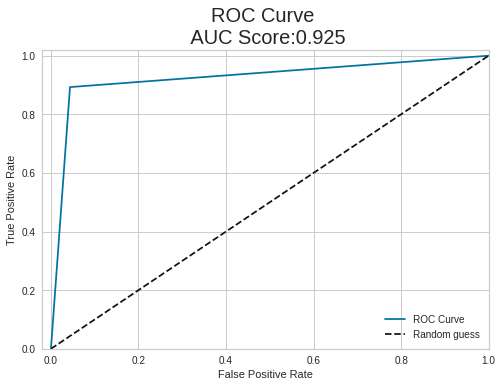

In [67]:

fpr, tpr, thresholds = roc_curve(test_target, preds)

# create plot
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
g = plt.xlabel('False Positive Rate')
g = plt.ylabel('True Positive Rate')
g = plt.title('ROC Curve \n AUC Score:{0:.3f}'.format(roc_auc_score(test_target, preds)), fontsize=20)
g = plt.xlim([-0.02, 1])
g = plt.ylim([0, 1.02])
g = plt.legend(loc="lower right")

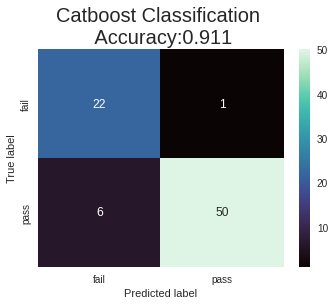

True Negatives:  22
False Positives:  1
False Negatives:  6
True Positives:  50


In [68]:
cm = confusion_matrix(test_target, preds)

cm_df = pd.DataFrame(cm,
                     index = ['fail','pass'],
                     columns = ['fail','pass'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True, cmap='mako')
plt.title('Catboost Classification \n Accuracy:{0:.3f}'.format(accuracy_score(test_target, preds)), fontsize=20)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

#extracting true_positives, false_positives, true_negatives, false_negatives
tn, fp, fn, tp = confusion_matrix(test_target, preds).ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)

In [69]:
pd.DataFrame(preds).value_counts()

1    51
0    28
dtype: int64

## B) Modeling After the First Trimester (G1) for Pass/Fail


In [70]:
features = ['absences','Mjob','failures','age','guardian','Medu','Fjob','famrel','Walc',
            'reason','studytime','goout','freetime','romantic','Dalc','traveltime','health','Pstatus',
            'activities','nursery','schoolsup','G1']
target = ['pass']

In [71]:
train_features = train_df[features]
train_target = train_df[target]

test_features = test_df[features]
test_target = test_df[target]

In [72]:
def objective(trial):

    params = {
        'iterations' : trial.suggest_int('iterations', 50, 300),
        'depth' : trial.suggest_int('depth', 2, 10),
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'random_strength' :trial.suggest_int('random_strength', 0, 100),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"])
    }

    # Conditional Hyper-Parameters
    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.5, 0.99)
    elif params["bootstrap_type"] == "MVS":
        params["subsample"] = trial.suggest_float("subsample", 0.5, 0.99)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=my_seed)

    cv_scores = []

    for train_index, test_index in skf.split(train_features,train_target):

        train_x, valid_x = train_features.iloc[train_index], train_features.iloc[test_index]
        train_y, valid_y = train_target.iloc[train_index], train_target.iloc[test_index]  

        train_pool = cb.Pool(train_x, train_y, cat_features=categorical_features_indices)
        valid_pool = cb.Pool(valid_x, valid_y, cat_features=categorical_features_indices)

        cb_class_model = cb.CatBoostClassifier(**params, random_state=my_seed)

        cb_class_optuna = cb_class_model.fit(train_pool, eval_set=valid_pool, verbose=False, 
                                         early_stopping_rounds=100, use_best_model=True)

        preds = cb_class_optuna.predict(valid_x)

        ROC_AUC = roc_auc_score(valid_y, preds)

        cv_scores.append(ROC_AUC)

    cv_avg_score = np.mean(cv_scores)    

    print('Avg ROC AUC score of CV CatBoost Classification=', cv_avg_score)

    return cv_avg_score

In [73]:
study = optuna.create_study(direction="maximize", sampler = TPESampler(seed=my_seed), study_name="Trimester 1 Classification")
study.optimize(objective, n_trials=300, n_jobs=-1)

`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.5380952380952382
Avg ROC AUC score of CV CatBoost Classification= 0.5166666666666667


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.5826839826839827
Avg ROC AUC score of CV CatBoost Classification= 0.7194805194805195
Avg ROC AUC score of CV CatBoost Classification= 0.80437123851758
Avg ROC AUC score of CV CatBoost Classification= 0.7936067997043607
Avg ROC AUC score of CV CatBoost Classification= 0.5116883116883117
Avg ROC AUC score of CV CatBoost Classification= 0.7419332699820504
Avg ROC AUC score of CV CatBoost Classification= 0.5
Avg ROC AUC score of CV CatBoost Classification= 0.5
Avg ROC AUC score of CV CatBoost Classification= 0.7836500897476506
Avg ROC AUC score of CV CatBoost Classification= 0.7595079717030937
Avg ROC AUC score of CV CatBoost Classification= 0.7786136627600042
Avg ROC AUC score of CV CatBoost Classification= 0.7790465631929046
Avg ROC AUC score of CV CatBoost Classification= 0.7905184246647661
Avg ROC AUC score of CV CatBoost Classification= 0.7763910885862105
Avg ROC AUC score of CV CatBoost Classification= 0.64004329004329


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.7234769295744905
Avg ROC AUC score of CV CatBoost Classification= 0.5136363636363637


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.7583254144229754
Avg ROC AUC score of CV CatBoost Classification= 0.5095238095238095
Avg ROC AUC score of CV CatBoost Classification= 0.5095238095238095
Avg ROC AUC score of CV CatBoost Classification= 0.7717453278428887


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.7817601098088904
Avg ROC AUC score of CV CatBoost Classification= 0.7835920177383592
Avg ROC AUC score of CV CatBoost Classification= 0.7973867595818815
Avg ROC AUC score of CV CatBoost Classification= 0.8121053743004962
Avg ROC AUC score of CV CatBoost Classification= 0.7910093971069582
Avg ROC AUC score of CV CatBoost Classification= 0.7834758737197761
Avg ROC AUC score of CV CatBoost Classification= 0.8170414950902755
Avg ROC AUC score of CV CatBoost Classification= 0.7996674057649668


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.7843575124062929
Avg ROC AUC score of CV CatBoost Classification= 0.7951800232288037


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.8004329004329005


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.7936648717136523


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.7936067997043608


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.7860891141378946
Avg ROC AUC score of CV CatBoost Classification= 0.5378787878787878


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.5095238095238095
Avg ROC AUC score of CV CatBoost Classification= 0.564069264069264
Avg ROC AUC score of CV CatBoost Classification= 0.5380952380952382
Avg ROC AUC score of CV CatBoost Classification= 0.7500422341885757


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.803405131453912


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.7979938760426565


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.7869549150036955


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.7817601098088903


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.7759159539647345
Avg ROC AUC score of CV CatBoost Classification= 0.7962622743110547
Avg ROC AUC score of CV CatBoost Classification= 0.7946890507866118
Avg ROC AUC score of CV CatBoost Classification= 0.8003167564143174
Avg ROC AUC score of CV CatBoost Classification= 0.7976612818076233
Avg ROC AUC score of CV CatBoost Classification= 0.8045296167247387
Avg ROC AUC score of CV CatBoost Classification= 0.7952222574173795
Avg ROC AUC score of CV CatBoost Classification= 0.8164924506387921
Avg ROC AUC score of CV CatBoost Classification= 0.8022067363530778


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.7859729701193116
Avg ROC AUC score of CV CatBoost Classification= 0.7723366064829479
Avg ROC AUC score of CV CatBoost Classification= 0.7948474289937704
Avg ROC AUC score of CV CatBoost Classification= 0.7977193538169149
Avg ROC AUC score of CV CatBoost Classification= 0.7835339457290678
Avg ROC AUC score of CV CatBoost Classification= 0.8089166930630347


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.8115140956604371
Avg ROC AUC score of CV CatBoost Classification= 0.7797962200401225
Avg ROC AUC score of CV CatBoost Classification= 0.8095660437123853
Avg ROC AUC score of CV CatBoost Classification= 0.7770985112448526
Avg ROC AUC score of CV CatBoost Classification= 0.7690317812269032
Avg ROC AUC score of CV CatBoost Classification= 0.7739520641959666
Avg ROC AUC score of CV CatBoost Classification= 0.7980941822405238
Avg ROC AUC score of CV CatBoost Classification= 0.7697972758948368
Avg ROC AUC score of CV CatBoost Classification= 0.7933322774786189
Avg ROC AUC score of CV CatBoost Classification= 0.8001003061978672
Avg ROC AUC score of CV CatBoost Classification= 0.795280329426671
Avg ROC AUC score of CV CatBoost Classification= 0.7812110653574068
Avg ROC AUC score of CV CatBoost Classification= 0.7907929468905077
Avg ROC AUC score of CV CatBoost Classification= 0.7978777320240735
Avg ROC AUC score of CV CatBoost Classification= 

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.7793210854186465


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.8045296167247387
Avg ROC AUC score of CV CatBoost Classification= 0.772452750501531
Avg ROC AUC score of CV CatBoost Classification= 0.8122215183190793
Avg ROC AUC score of CV CatBoost Classification= 0.7788301129764544


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.7912258473234083


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.8115721676697287


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.781311371555274


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.8067521908985323
Avg ROC AUC score of CV CatBoost Classification= 0.7976612818076234
Avg ROC AUC score of CV CatBoost Classification= 0.781427515573857
Avg ROC AUC score of CV CatBoost Classification= 0.795496779643121
Avg ROC AUC score of CV CatBoost Classification= 0.7907348748812163
Avg ROC AUC score of CV CatBoost Classification= 0.7737936859888079
Avg ROC AUC score of CV CatBoost Classification= 0.795496779643121


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.7952222574173793
Avg ROC AUC score of CV CatBoost Classification= 0.7833755675219091
Avg ROC AUC score of CV CatBoost Classification= 0.8140534262485483
Avg ROC AUC score of CV CatBoost Classification= 0.8259159539647346
Avg ROC AUC score of CV CatBoost Classification= 0.8025815647766867
Avg ROC AUC score of CV CatBoost Classification= 0.818815331010453
Avg ROC AUC score of CV CatBoost Classification= 0.8018319079294688
Avg ROC AUC score of CV CatBoost Classification= 0.8094076655052266
Avg ROC AUC score of CV CatBoost Classification= 0.7909513250976666
Avg ROC AUC score of CV CatBoost Classification= 0.7945729067680287
Avg ROC AUC score of CV CatBoost Classification= 0.7926829268292683
Avg ROC AUC score of CV CatBoost Classification= 0.7793791574279381
Avg ROC AUC score of CV CatBoost Classification= 0.7887868229331644


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.7882958504909725
Avg ROC AUC score of CV CatBoost Classification= 0.7951219512195122
Avg ROC AUC score of CV CatBoost Classification= 0.7947312849751874


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.8074015415478831
Avg ROC AUC score of CV CatBoost Classification= 0.7879210220673636
Avg ROC AUC score of CV CatBoost Classification= 0.7973867595818815


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.787862950058072
Avg ROC AUC score of CV CatBoost Classification= 0.7971122373561398
Avg ROC AUC score of CV CatBoost Classification= 0.7804033365008975
Avg ROC AUC score of CV CatBoost Classification= 0.7924664766128181


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.8003748284236089


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.7863055643543448
Avg ROC AUC score of CV CatBoost Classification= 0.8178333861260692
Avg ROC AUC score of CV CatBoost Classification= 0.7717453278428887
Avg ROC AUC score of CV CatBoost Classification= 0.811397951641854
Avg ROC AUC score of CV CatBoost Classification= 0.8025815647766867
Avg ROC AUC score of CV CatBoost Classification= 0.7924084046035266


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.8025393305881112
Avg ROC AUC score of CV CatBoost Classification= 0.7900855242318657
Avg ROC AUC score of CV CatBoost Classification= 0.8160595502058918
Avg ROC AUC score of CV CatBoost Classification= 0.8256414317389927


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.8257417379368599
Avg ROC AUC score of CV CatBoost Classification= 0.7952803294266709
Avg ROC AUC score of CV CatBoost Classification= 0.7744430366381586
Avg ROC AUC score of CV CatBoost Classification= 0.7809365431316653


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.813836976032098
Avg ROC AUC score of CV CatBoost Classification= 0.8140534262485482
Avg ROC AUC score of CV CatBoost Classification= 0.8163340724316335


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.7766656108119523
Avg ROC AUC score of CV CatBoost Classification= 0.7845158906134515


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.8162179284130502
Avg ROC AUC score of CV CatBoost Classification= 0.8022067363530778


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.7998257839721254
Avg ROC AUC score of CV CatBoost Classification= 0.8164924506387921
Avg ROC AUC score of CV CatBoost Classification= 0.8117305458768873
Avg ROC AUC score of CV CatBoost Classification= 0.8115140956604371
Avg ROC AUC score of CV CatBoost Classification= 0.8069686411149826
Avg ROC AUC score of CV CatBoost Classification= 0.7949477351916376


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.8135202196177808
Avg ROC AUC score of CV CatBoost Classification= 0.8025815647766867
Avg ROC AUC score of CV CatBoost Classification= 0.7999260901699927
Avg ROC AUC score of CV CatBoost Classification= 0.7950058072009292


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.8096241157216767
Avg ROC AUC score of CV CatBoost Classification= 0.8284552845528456
Avg ROC AUC score of CV CatBoost Classification= 0.7951219512195122
Avg ROC AUC score of CV CatBoost Classification= 0.8063192904656319
Avg ROC AUC score of CV CatBoost Classification= 0.8002586844050258
Avg ROC AUC score of CV CatBoost Classification= 0.7695227536690952
Avg ROC AUC score of CV CatBoost Classification= 0.7931158272621688
Avg ROC AUC score of CV CatBoost Classification= 0.7905184246647663


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.8094076655052266
Avg ROC AUC score of CV CatBoost Classification= 0.778888184985746
Avg ROC AUC score of CV CatBoost Classification= 0.7921919543870763
Avg ROC AUC score of CV CatBoost Classification= 0.7645443986907402
Avg ROC AUC score of CV CatBoost Classification= 0.797819660014782
Avg ROC AUC score of CV CatBoost Classification= 0.7993348115299335
Avg ROC AUC score of CV CatBoost Classification= 0.788470066518847


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.8210959771935382
Avg ROC AUC score of CV CatBoost Classification= 0.7810368493295323
Avg ROC AUC score of CV CatBoost Classification= 0.7907348748812164
Avg ROC AUC score of CV CatBoost Classification= 0.7861894203357617
Avg ROC AUC score of CV CatBoost Classification= 0.7880794002745223
Avg ROC AUC score of CV CatBoost Classification= 0.7536796536796537


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.804862210959772
Avg ROC AUC score of CV CatBoost Classification= 0.7998257839721254
Avg ROC AUC score of CV CatBoost Classification= 0.7738517579980995


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.8017738359201774
Avg ROC AUC score of CV CatBoost Classification= 0.8024231865695282
Avg ROC AUC score of CV CatBoost Classification= 0.8095660437123853
Avg ROC AUC score of CV CatBoost Classification= 0.8050205891669308
Avg ROC AUC score of CV CatBoost Classification= 0.80437123851758
Avg ROC AUC score of CV CatBoost Classification= 0.7976612818076233
Avg ROC AUC score of CV CatBoost Classification= 0.7791046352021963
Avg ROC AUC score of CV CatBoost Classification= 0.8164343786295005
Avg ROC AUC score of CV CatBoost Classification= 0.769797275894837
Avg ROC AUC score of CV CatBoost Classification= 0.8089166930630345
Avg ROC AUC score of CV CatBoost Classification= 0.7950638792102207


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.7882377784816811
Avg ROC AUC score of CV CatBoost Classification= 0.8021486643437863
Avg ROC AUC score of CV CatBoost Classification= 0.8045876887340302


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.7719617780593391
Avg ROC AUC score of CV CatBoost Classification= 0.8305617147080561
Avg ROC AUC score of CV CatBoost Classification= 0.7999841621792841
Avg ROC AUC score of CV CatBoost Classification= 0.7835920177383592
Avg ROC AUC score of CV CatBoost Classification= 0.823418857565199
Avg ROC AUC score of CV CatBoost Classification= 0.7745011086474503
Avg ROC AUC score of CV CatBoost Classification= 0.7950638792102207


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.8279643121106535
Avg ROC AUC score of CV CatBoost Classification= 0.7974870657797487
Avg ROC AUC score of CV CatBoost Classification= 0.7927251610178441


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.7999841621792841


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.7928413050364269
Avg ROC AUC score of CV CatBoost Classification= 0.8048041389504805
Avg ROC AUC score of CV CatBoost Classification= 0.7879210220673636
Avg ROC AUC score of CV CatBoost Classification= 0.8047460669411889
Avg ROC AUC score of CV CatBoost Classification= 0.8135624538063564
Avg ROC AUC score of CV CatBoost Classification= 0.8068524970963994
Avg ROC AUC score of CV CatBoost Classification= 0.8140534262485482
Avg ROC AUC score of CV CatBoost Classification= 0.8300126702565727
Avg ROC AUC score of CV CatBoost Classification= 0.8045296167247388
Avg ROC AUC score of CV CatBoost Classification= 0.7811529933481153
Avg ROC AUC score of CV CatBoost Classification= 0.7925667828106853


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.7929416112342942
Avg ROC AUC score of CV CatBoost Classification= 0.8213124274099883
Avg ROC AUC score of CV CatBoost Classification= 0.8001003061978672


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.8021064301552107
Avg ROC AUC score of CV CatBoost Classification= 0.79732868757259


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.8095660437123853
Avg ROC AUC score of CV CatBoost Classification= 0.800142540386443
Avg ROC AUC score of CV CatBoost Classification= 0.8329426670890084
Avg ROC AUC score of CV CatBoost Classification= 0.7946309787773203
Avg ROC AUC score of CV CatBoost Classification= 0.819422447471228
Avg ROC AUC score of CV CatBoost Classification= 0.8161598564037588


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.7726692007179812
Avg ROC AUC score of CV CatBoost Classification= 0.8117305458768873
Avg ROC AUC score of CV CatBoost Classification= 0.8070267131242741


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.809465737514518
Avg ROC AUC score of CV CatBoost Classification= 0.7833174955126175


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.798426776475557
Avg ROC AUC score of CV CatBoost Classification= 0.7841410621898426


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.8242424242424242
Avg ROC AUC score of CV CatBoost Classification= 0.7886865167352972


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.8003167564143172
Avg ROC AUC score of CV CatBoost Classification= 0.7885703727167142
Avg ROC AUC score of CV CatBoost Classification= 0.8094076655052265
Avg ROC AUC score of CV CatBoost Classification= 0.7928993770457184
Avg ROC AUC score of CV CatBoost Classification= 0.7761324041811847
Avg ROC AUC score of CV CatBoost Classification= 0.7836923239362265
Avg ROC AUC score of CV CatBoost Classification= 0.8281226903178123
Avg ROC AUC score of CV CatBoost Classification= 0.7999260901699926
Avg ROC AUC score of CV CatBoost Classification= 0.7976612818076232
Avg ROC AUC score of CV CatBoost Classification= 0.8066941188892409
Avg ROC AUC score of CV CatBoost Classification= 0.7864639425615035


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.7805036426987647
Avg ROC AUC score of CV CatBoost Classification= 0.805237039383381
Avg ROC AUC score of CV CatBoost Classification= 0.8069686411149826


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.8168250448738252
Avg ROC AUC score of CV CatBoost Classification= 0.8096241157216767


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.8233027135466159
Avg ROC AUC score of CV CatBoost Classification= 0.8024812585788196


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.7914422975398586
Avg ROC AUC score of CV CatBoost Classification= 0.8019322141273362
Avg ROC AUC score of CV CatBoost Classification= 0.8022067363530778
Avg ROC AUC score of CV CatBoost Classification= 0.8134040755991976
Avg ROC AUC score of CV CatBoost Classification= 0.7973867595818815


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.7958293738781543


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.8147186147186147
Avg ROC AUC score of CV CatBoost Classification= 0.806910569105691
Avg ROC AUC score of CV CatBoost Classification= 0.771254355400697
Avg ROC AUC score of CV CatBoost Classification= 0.8094076655052265
Avg ROC AUC score of CV CatBoost Classification= 0.8051367331855138
Avg ROC AUC score of CV CatBoost Classification= 0.799392883539225
Avg ROC AUC score of CV CatBoost Classification= 0.792350332594235
Avg ROC AUC score of CV CatBoost Classification= 0.7788301129764544
Avg ROC AUC score of CV CatBoost Classification= 0.7926829268292682


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.8119469960933376


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.8114560236511454
Avg ROC AUC score of CV CatBoost Classification= 0.8165505226480837
Avg ROC AUC score of CV CatBoost Classification= 0.8136205258156478
Avg ROC AUC score of CV CatBoost Classification= 0.7957713018688629
Avg ROC AUC score of CV CatBoost Classification= 0.823318551367332


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.799883855981417


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.8070847851335656
Avg ROC AUC score of CV CatBoost Classification= 0.7952803294266709


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.7518899799387604
Avg ROC AUC score of CV CatBoost Classification= 0.6151515151515151
Avg ROC AUC score of CV CatBoost Classification= 0.8095660437123853
Avg ROC AUC score of CV CatBoost Classification= 0.792841305036427


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.8146605427093231
Avg ROC AUC score of CV CatBoost Classification= 0.7881374722838138
Avg ROC AUC score of CV CatBoost Classification= 0.8050205891669305
Avg ROC AUC score of CV CatBoost Classification= 0.8092492872980678
Avg ROC AUC score of CV CatBoost Classification= 0.8096821877309681
Avg ROC AUC score of CV CatBoost Classification= 0.8073434695385917
Avg ROC AUC score of CV CatBoost Classification= 0.7976032097983318
Avg ROC AUC score of CV CatBoost Classification= 0.7972283813747228
Avg ROC AUC score of CV CatBoost Classification= 0.7877045718509132
Avg ROC AUC score of CV CatBoost Classification= 0.8020905923344948


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.8020483581459192


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.7766656108119523
Avg ROC AUC score of CV CatBoost Classification= 0.8122215183190795


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.8213704994192799
Avg ROC AUC score of CV CatBoost Classification= 0.7982103262591067
Avg ROC AUC score of CV CatBoost Classification= 0.8024231865695282


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.7907929468905078
Avg ROC AUC score of CV CatBoost Classification= 0.8020483581459192
Avg ROC AUC score of CV CatBoost Classification= 0.8076179917643334


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.7959296800760215


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg ROC AUC score of CV CatBoost Classification= 0.7908932530883751
Avg ROC AUC score of CV CatBoost Classification= 0.8215869496357302
Avg ROC AUC score of CV CatBoost Classification= 0.814227642276423


In [74]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 300
Best trial:
  Value: 0.8329426670890084
  Params: 
    iterations: 291
    depth: 2
    learning_rate: 0.24971496042818853
    random_strength: 77
    od_type: IncToDec
    objective: Logloss
    colsample_bylevel: 0.09436454688618538
    boosting_type: Ordered
    bootstrap_type: Bayesian
    bagging_temperature: 9.9178778477227


In [75]:
optuna.visualization.plot_optimization_history(study)

In [76]:
best_model = cb.CatBoostClassifier()
best_model = best_model.set_params(**study.best_params)
best_model = best_model.fit(train_features, train_target, cat_features= categorical_features_indices, verbose=False, early_stopping_rounds=100)

preds = best_model.predict(test_features)

ROC_AUC_Score = roc_auc_score(test_target, preds)

print('ROC AUC Score of CatBoost =', ROC_AUC_Score)

ROC AUC Score of CatBoost = 0.8773291925465839


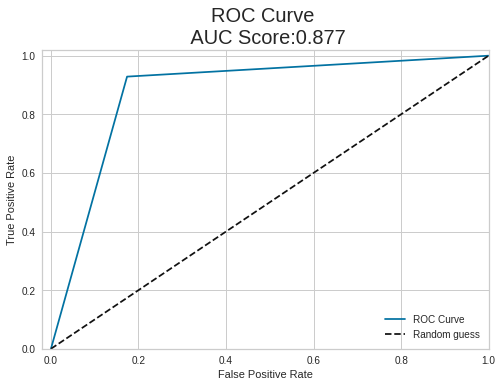

In [77]:

fpr, tpr, thresholds = roc_curve(test_target, preds)

# create plot
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
g = plt.xlabel('False Positive Rate')
g = plt.ylabel('True Positive Rate')
g = plt.title('ROC Curve \n AUC Score:{0:.3f}'.format(roc_auc_score(test_target, preds)), fontsize=20)
g = plt.xlim([-0.02, 1])
g = plt.ylim([0, 1.02])
g = plt.legend(loc="lower right")

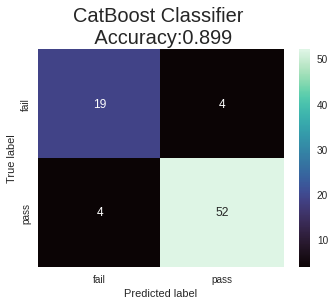

True Negatives:  19
False Positives:  4
False Negatives:  4
True Positives:  52


In [78]:
cm = confusion_matrix(test_target, preds)

cm_df = pd.DataFrame(cm,
                     index = ['fail','pass'],
                     columns = ['fail','pass'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True, cmap='mako')
plt.title('CatBoost Classifier \n Accuracy:{0:.3f}'.format(accuracy_score(test_target, preds)), fontsize=20)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

#extracting true_positives, false_positives, true_negatives, false_negatives
tn, fp, fn, tp = confusion_matrix(test_target, preds).ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)

In [79]:
pd.DataFrame(preds).value_counts()

1    56
0    23
dtype: int64

# 3) Multi Classification Modeling (Letter Grade)

## A) Modeling After the Second Trimester (G1, G2) for Letter Grade (A, B, C, D, F)

In [101]:
train_df , test_df = train_test_split(feature_df, test_size=0.2, random_state=my_seed, stratify=df['Grade'])

In [102]:
features = ['absences','Mjob','failures','age','guardian','Medu','Fjob','famrel','Walc',
            'reason','studytime','goout','freetime','romantic','Dalc','traveltime','health','Pstatus',
            'activities','nursery','schoolsup','G1', 'G2']
target = ['Grade']

In [103]:
train_features = train_df[features]
train_target = train_df[target]

test_features = test_df[features]
test_target = test_df[target]

In [104]:
def objective(trial):

    params = {

        'iterations' : trial.suggest_int('iterations', 50, 300),
        'depth' : trial.suggest_int('depth', 2, 10),
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'random_strength' :trial.suggest_int('random_strength', 0, 100),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"])
    }

    # Conditional Hyper-Parameters
    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.5, 0.99)
    elif params["bootstrap_type"] == "MVS":
        params["subsample"] = trial.suggest_float("subsample", 0.5, 0.99)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=my_seed)

    cv_scores = []

    for train_index, test_index in skf.split(train_features,train_target):

        train_x, valid_x = train_features.iloc[train_index], train_features.iloc[test_index]
        train_y, valid_y = train_target.iloc[train_index], train_target.iloc[test_index]  

        train_pool = cb.Pool(train_x, train_y, cat_features=categorical_features_indices)
        valid_pool = cb.Pool(valid_x, valid_y, cat_features=categorical_features_indices)

        classes = np.unique(train_y)
        weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_y.values.reshape(-1))
        class_weights = dict(zip(classes, weights))

        cb_multiclass_model = cb.CatBoostClassifier(**params, random_state=my_seed,
                                   loss_function='MultiClassOneVsAll', class_weights = class_weights)

        cb_multiclass_optuna = cb_multiclass_model.fit(train_pool, eval_set=valid_pool, verbose=False, 
                                         early_stopping_rounds=100, use_best_model=True)

        preds = cb_multiclass_optuna.predict(valid_x)

        F1 = f1_score(valid_y, preds, average='macro')

        cv_scores.append(F1)

    cv_avg_score = np.mean(cv_scores)    

    print('Avg F1 score of CV CatBoost Multi Classification=', cv_avg_score)

    return cv_avg_score


In [106]:
study = optuna.create_study(direction="maximize", sampler = TPESampler(seed=my_seed), study_name="Trimester 2 Multi Classification")
study.optimize(objective, n_trials=300, n_jobs=-1)

`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.6301027329609145
Avg F1 score of CV CatBoost Multi Classification= 0.5677608303631696
Avg F1 score of CV CatBoost Multi Classification= 0.5303925516908421
Avg F1 score of CV CatBoost Multi Classification= 0.4852438580851953


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.4427900281095193
Avg F1 score of CV CatBoost Multi Classification= 0.6138401988714636


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.6894046348314891
Avg F1 score of CV CatBoost Multi Classification= 0.5815543622257607
Avg F1 score of CV CatBoost Multi Classification= 0.5523969624552828
Avg F1 score of CV CatBoost Multi Classification= 0.555705649973195
Avg F1 score of CV CatBoost Multi Classification= 0.6681484028558383
Avg F1 score of CV CatBoost Multi Classification= 0.7095963270464829
Avg F1 score of CV CatBoost Multi Classification= 0.7222936228607478
Avg F1 score of CV CatBoost Multi Classification= 0.6993249687408947
Avg F1 score of CV CatBoost Multi Classification= 0.6982591327060145
Avg F1 score of CV CatBoost Multi Classification= 0.681711901298731
Avg F1 score of CV CatBoost Multi Classification= 0.6774371136449182


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.7049581506564956
Avg F1 score of CV CatBoost Multi Classification= 0.6703522530009967
Avg F1 score of CV CatBoost Multi Classification= 0.5127822425369617
Avg F1 score of CV CatBoost Multi Classification= 0.5589117450593414
Avg F1 score of CV CatBoost Multi Classification= 0.6823726197779909
Avg F1 score of CV CatBoost Multi Classification= 0.6840927688109005
Avg F1 score of CV CatBoost Multi Classification= 0.712215022455297
Avg F1 score of CV CatBoost Multi Classification= 0.6462143307346738


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.6939486805442897
Avg F1 score of CV CatBoost Multi Classification= 0.7244498972207613


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.6166875437920186
Avg F1 score of CV CatBoost Multi Classification= 0.38930165662267113
Avg F1 score of CV CatBoost Multi Classification= 0.587928418856698
Avg F1 score of CV CatBoost Multi Classification= 0.638123118278392
Avg F1 score of CV CatBoost Multi Classification= 0.6084451759312538
Avg F1 score of CV CatBoost Multi Classification= 0.7016370893588416
Avg F1 score of CV CatBoost Multi Classification= 0.6844225264936684
Avg F1 score of CV CatBoost Multi Classification= 0.7143911084389799


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.6688242522494111
Avg F1 score of CV CatBoost Multi Classification= 0.662394814829059
Avg F1 score of CV CatBoost Multi Classification= 0.6403975633630365
Avg F1 score of CV CatBoost Multi Classification= 0.6643174245499348
Avg F1 score of CV CatBoost Multi Classification= 0.6928642102563037
Avg F1 score of CV CatBoost Multi Classification= 0.6735968062028179
Avg F1 score of CV CatBoost Multi Classification= 0.6192044032651444


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.7067189849261457


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.7095388886246669
Avg F1 score of CV CatBoost Multi Classification= 0.7168326403546832
Avg F1 score of CV CatBoost Multi Classification= 0.7380239678851526
Avg F1 score of CV CatBoost Multi Classification= 0.6737938620287778
Avg F1 score of CV CatBoost Multi Classification= 0.6903607314393747
Avg F1 score of CV CatBoost Multi Classification= 0.6973590082358854


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.7222402804966426
Avg F1 score of CV CatBoost Multi Classification= 0.71423217788763


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.7121890459467277
Avg F1 score of CV CatBoost Multi Classification= 0.7228042636117141
Avg F1 score of CV CatBoost Multi Classification= 0.6920413937919229
Avg F1 score of CV CatBoost Multi Classification= 0.7250768789895674
Avg F1 score of CV CatBoost Multi Classification= 0.7220581416815064


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.6232798133392699
Avg F1 score of CV CatBoost Multi Classification= 0.6782241395636989
Avg F1 score of CV CatBoost Multi Classification= 0.6682620619208419
Avg F1 score of CV CatBoost Multi Classification= 0.7042164438160581
Avg F1 score of CV CatBoost Multi Classification= 0.7066510852997203
Avg F1 score of CV CatBoost Multi Classification= 0.6899856108729893
Avg F1 score of CV CatBoost Multi Classification= 0.7128756743447218
Avg F1 score of CV CatBoost Multi Classification= 0.7153455037977297
Avg F1 score of CV CatBoost Multi Classification= 0.6376105856567824
Avg F1 score of CV CatBoost Multi Classification= 0.7048920609859067
Avg F1 score of CV CatBoost Multi Classification= 0.7191909354335413


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.7175356839864602
Avg F1 score of CV CatBoost Multi Classification= 0.7103354096919602
Avg F1 score of CV CatBoost Multi Classification= 0.6557837986093531
Avg F1 score of CV CatBoost Multi Classification= 0.6905346368600561
Avg F1 score of CV CatBoost Multi Classification= 0.7121786650920572


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.6690168750296565
Avg F1 score of CV CatBoost Multi Classification= 0.7165331129876291


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.692572679829367
Avg F1 score of CV CatBoost Multi Classification= 0.7258213393785082


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.7050922986500643
Avg F1 score of CV CatBoost Multi Classification= 0.6803006509887733
Avg F1 score of CV CatBoost Multi Classification= 0.723300061344649
Avg F1 score of CV CatBoost Multi Classification= 0.676251188602594
Avg F1 score of CV CatBoost Multi Classification= 0.7177230847020859


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.6491434797058806
Avg F1 score of CV CatBoost Multi Classification= 0.6671269379824054
Avg F1 score of CV CatBoost Multi Classification= 0.45538653275797325
Avg F1 score of CV CatBoost Multi Classification= 0.6714893269772879


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.6115849630729265
Avg F1 score of CV CatBoost Multi Classification= 0.725248043315343
Avg F1 score of CV CatBoost Multi Classification= 0.6902452725104925
Avg F1 score of CV CatBoost Multi Classification= 0.696585287644787
Avg F1 score of CV CatBoost Multi Classification= 0.7365774533966962
Avg F1 score of CV CatBoost Multi Classification= 0.7282225351375321


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.7038729579891025
Avg F1 score of CV CatBoost Multi Classification= 0.7004513983988676
Avg F1 score of CV CatBoost Multi Classification= 0.7286955703194222
Avg F1 score of CV CatBoost Multi Classification= 0.6837389238096531
Avg F1 score of CV CatBoost Multi Classification= 0.650992103259478
Avg F1 score of CV CatBoost Multi Classification= 0.7492591356151728
Avg F1 score of CV CatBoost Multi Classification= 0.67553174299346
Avg F1 score of CV CatBoost Multi Classification= 0.7286649816501424
Avg F1 score of CV CatBoost Multi Classification= 0.7243229466781514
Avg F1 score of CV CatBoost Multi Classification= 0.7313381920868225
Avg F1 score of CV CatBoost Multi Classification= 0.7363458471236659
Avg F1 score of CV CatBoost Multi Classification= 0.7138341737017416
Avg F1 score of CV CatBoost Multi Classification= 0.7115391083618132
Avg F1 score of CV CatBoost Multi Classification= 0.6777623414716437


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.6965184925715564
Avg F1 score of CV CatBoost Multi Classification= 0.7253431654427624
Avg F1 score of CV CatBoost Multi Classification= 0.7096161118574912
Avg F1 score of CV CatBoost Multi Classification= 0.7058148819208855
Avg F1 score of CV CatBoost Multi Classification= 0.7124339548297954


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.723102501967586
Avg F1 score of CV CatBoost Multi Classification= 0.7129142835953732
Avg F1 score of CV CatBoost Multi Classification= 0.7102979740279076
Avg F1 score of CV CatBoost Multi Classification= 0.7327422579525434
Avg F1 score of CV CatBoost Multi Classification= 0.7070866207633543
Avg F1 score of CV CatBoost Multi Classification= 0.7104471369082932
Avg F1 score of CV CatBoost Multi Classification= 0.7300070451817552
Avg F1 score of CV CatBoost Multi Classification= 0.7266041137579521
Avg F1 score of CV CatBoost Multi Classification= 0.6886428964408996
Avg F1 score of CV CatBoost Multi Classification= 0.7093332947331887
Avg F1 score of CV CatBoost Multi Classification= 0.7149598728384381


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.6896186303375162
Avg F1 score of CV CatBoost Multi Classification= 0.7128427894651803
Avg F1 score of CV CatBoost Multi Classification= 0.737564527261821
Avg F1 score of CV CatBoost Multi Classification= 0.7214889063409065
Avg F1 score of CV CatBoost Multi Classification= 0.7410496189013864
Avg F1 score of CV CatBoost Multi Classification= 0.7208392681157245
Avg F1 score of CV CatBoost Multi Classification= 0.6938283647924627
Avg F1 score of CV CatBoost Multi Classification= 0.6947964988228147
Avg F1 score of CV CatBoost Multi Classification= 0.7323464288684074
Avg F1 score of CV CatBoost Multi Classification= 0.551539377596255
Avg F1 score of CV CatBoost Multi Classification= 0.6979618216867172
Avg F1 score of CV CatBoost Multi Classification= 0.706223495926471
Avg F1 score of CV CatBoost Multi Classification= 0.7146191748273043
Avg F1 score of CV CatBoost Multi Classification= 0.7123911427845451


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.7029397246513952
Avg F1 score of CV CatBoost Multi Classification= 0.6981831961679145
Avg F1 score of CV CatBoost Multi Classification= 0.6773940653206021
Avg F1 score of CV CatBoost Multi Classification= 0.6863339159209431
Avg F1 score of CV CatBoost Multi Classification= 0.6756743695432462
Avg F1 score of CV CatBoost Multi Classification= 0.7088499547633834
Avg F1 score of CV CatBoost Multi Classification= 0.717647194149132
Avg F1 score of CV CatBoost Multi Classification= 0.7021020536140237
Avg F1 score of CV CatBoost Multi Classification= 0.7163875714902412
Avg F1 score of CV CatBoost Multi Classification= 0.7251270675679311
Avg F1 score of CV CatBoost Multi Classification= 0.7060990553105233
Avg F1 score of CV CatBoost Multi Classification= 0.6991920879979453


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.7244577423551093
Avg F1 score of CV CatBoost Multi Classification= 0.6939524952367078


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.6907178400358684
Avg F1 score of CV CatBoost Multi Classification= 0.6766069990227956
Avg F1 score of CV CatBoost Multi Classification= 0.7124841492407897
Avg F1 score of CV CatBoost Multi Classification= 0.7054710514416482


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.6865986585511082
Avg F1 score of CV CatBoost Multi Classification= 0.7213733250210445
Avg F1 score of CV CatBoost Multi Classification= 0.6762089522078312
Avg F1 score of CV CatBoost Multi Classification= 0.7375112866428655
Avg F1 score of CV CatBoost Multi Classification= 0.7163884664305648
Avg F1 score of CV CatBoost Multi Classification= 0.7380779870677014
Avg F1 score of CV CatBoost Multi Classification= 0.7314697107983252
Avg F1 score of CV CatBoost Multi Classification= 0.7014487829972917
Avg F1 score of CV CatBoost Multi Classification= 0.7070991415906749
Avg F1 score of CV CatBoost Multi Classification= 0.7069189900381193
Avg F1 score of CV CatBoost Multi Classification= 0.7014736588321727
Avg F1 score of CV CatBoost Multi Classification= 0.7432546264727856
Avg F1 score of CV CatBoost Multi Classification= 0.6949607772969788
Avg F1 score of CV CatBoost Multi Classification= 0.7059379170107686
Avg F1 score of CV CatBoost Multi 

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.7027773033947422
Avg F1 score of CV CatBoost Multi Classification= 0.7286878957662312
Avg F1 score of CV CatBoost Multi Classification= 0.7162508419445006
Avg F1 score of CV CatBoost Multi Classification= 0.7201683332766564
Avg F1 score of CV CatBoost Multi Classification= 0.7244206047996041
Avg F1 score of CV CatBoost Multi Classification= 0.7321854148204421
Avg F1 score of CV CatBoost Multi Classification= 0.7260299115082774
Avg F1 score of CV CatBoost Multi Classification= 0.7341846163861684
Avg F1 score of CV CatBoost Multi Classification= 0.7411520529769684
Avg F1 score of CV CatBoost Multi Classification= 0.7215475947224034
Avg F1 score of CV CatBoost Multi Classification= 0.75516487274382
Avg F1 score of CV CatBoost Multi Classification= 0.7354227598738092
Avg F1 score of CV CatBoost Multi Classification= 0.7545181893430447
Avg F1 score of CV CatBoost Multi Classification= 0.734934572917141
Avg F1 score of CV CatBoost Multi Cla

Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.7330289396959098
Avg F1 score of CV CatBoost Multi Classification= 0.7413725752085263
Avg F1 score of CV CatBoost Multi Classification= 0.6963264980525885
Avg F1 score of CV CatBoost Multi Classification= 0.7240045970624461
Avg F1 score of CV CatBoost Multi Classification= 0.7159765201737838
Avg F1 score of CV CatBoost Multi Classification= 0.7210492999267096
Avg F1 score of CV CatBoost Multi Classification= 0.7450971502047181


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.7201713016076143
Avg F1 score of CV CatBoost Multi Classification= 0.7236358024782195


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.7389496120946081
Avg F1 score of CV CatBoost Multi Classification= 0.7008087156604385


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.6740977786838418
Avg F1 score of CV CatBoost Multi Classification= 0.6423466125141946


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.7020838357995102
Avg F1 score of CV CatBoost Multi Classification= 0.6997199481965579


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.7353345481407498


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.7130100250431577
Avg F1 score of CV CatBoost Multi Classification= 0.7225736457238383


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.742582546693073


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.7180150669568336
Avg F1 score of CV CatBoost Multi Classification= 0.7277754058397446


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.6017056107195499
Avg F1 score of CV CatBoost Multi Classification= 0.732036298970481
Avg F1 score of CV CatBoost Multi Classification= 0.6873620976023722
Avg F1 score of CV CatBoost Multi Classification= 0.7118504174157885
Avg F1 score of CV CatBoost Multi Classification= 0.7275108209347417
Avg F1 score of CV CatBoost Multi Classification= 0.741688791318122
Avg F1 score of CV CatBoost Multi Classification= 0.7240130996239214
Avg F1 score of CV CatBoost Multi Classification= 0.7193580348324594
Avg F1 score of CV CatBoost Multi Classification= 0.7378276802852974
Avg F1 score of CV CatBoost Multi Classification= 0.7376267389381748
Avg F1 score of CV CatBoost Multi Classification= 0.733130406770633
Avg F1 score of CV CatBoost Multi Classification= 0.7363431987571898
Avg F1 score of CV CatBoost Multi Classification= 0.7237952129457201
Avg F1 score of CV CatBoost Multi Classification= 0.7166515561193652


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.7068874275766859
Avg F1 score of CV CatBoost Multi Classification= 0.735351149781885
Avg F1 score of CV CatBoost Multi Classification= 0.7071508594630311
Avg F1 score of CV CatBoost Multi Classification= 0.7153909847967903


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.6812593123222134


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.7275706163600901
Avg F1 score of CV CatBoost Multi Classification= 0.6750792730180439
Avg F1 score of CV CatBoost Multi Classification= 0.7196594580062577
Avg F1 score of CV CatBoost Multi Classification= 0.5665178848635704
Avg F1 score of CV CatBoost Multi Classification= 0.7346858734588254
Avg F1 score of CV CatBoost Multi Classification= 0.7047619759719309


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.7548736444733629


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.7113618598621901
Avg F1 score of CV CatBoost Multi Classification= 0.735861457372027
Avg F1 score of CV CatBoost Multi Classification= 0.7175286941504971
Avg F1 score of CV CatBoost Multi Classification= 0.7421084968766319
Avg F1 score of CV CatBoost Multi Classification= 0.7362567390817591
Avg F1 score of CV CatBoost Multi Classification= 0.729283981519749
Avg F1 score of CV CatBoost Multi Classification= 0.6684276132534077
Avg F1 score of CV CatBoost Multi Classification= 0.7311115134345266
Avg F1 score of CV CatBoost Multi Classification= 0.7382781408865073
Avg F1 score of CV CatBoost Multi Classification= 0.7480248538923269
Avg F1 score of CV CatBoost Multi Classification= 0.735737249506301
Avg F1 score of CV CatBoost Multi Classification= 0.7367602918033657
Avg F1 score of CV CatBoost Multi Classification= 0.7244595298095214
Avg F1 score of CV CatBoost Multi Classification= 0.7020958429311441
Avg F1 score of CV CatBoost Multi Cla

In [107]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 300
Best trial:
  Value: 0.75516487274382
  Params: 
    iterations: 300
    depth: 4
    learning_rate: 0.21245466412044894
    random_strength: 57
    od_type: Iter
    colsample_bylevel: 0.0880397301976544
    boosting_type: Ordered
    bootstrap_type: Bayesian
    bagging_temperature: 0.23133753377675598


In [108]:
optuna.visualization.plot_optimization_history(study)

In [109]:
classes = np.unique(train_target)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_target.values.reshape(-1))
class_weights = dict(zip(classes, weights))

best_model = cb.CatBoostClassifier(loss_function='MultiClassOneVsAll', class_weights = class_weights)
best_model = best_model.set_params(**study.best_params)
best_model = best_model.fit(train_features, train_target, cat_features= categorical_features_indices, verbose=False, early_stopping_rounds=100)

preds = best_model.predict(test_features)

f1score = f1_score(test_target, preds, average='macro')

print('F1 Score of CatBoost =', f1score)


F1 Score of CatBoost = 0.7043918447144254


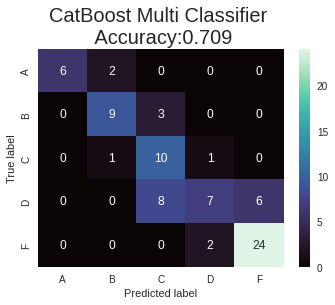

In [110]:
cm = confusion_matrix(test_target, preds)


cm_df = pd.DataFrame(cm,
                     index = ['A','B','C','D','F'],
                     columns = ['A','B','C','D','F'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True, cmap='mako')
plt.title('CatBoost Multi Classifier \n Accuracy:{0:.3f}'.format(accuracy_score(test_target, preds)), fontsize=20)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [111]:
pd.DataFrame(preds).value_counts()

F    30
C    21
B    12
D    10
A     6
dtype: int64

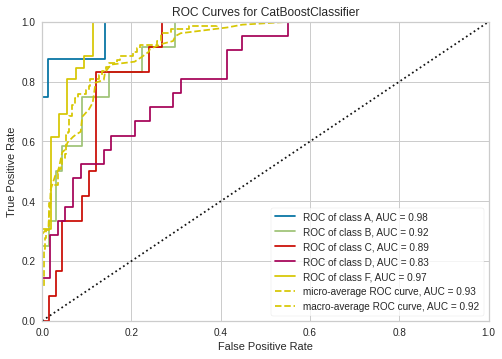

In [112]:
yellowbrick_model = wrap(best_model)
visualizer = ROCAUC(yellowbrick_model)
visualizer.fit(train_features, train_target)
visualizer.score(test_features, test_target)
visualizer.show()

## B) Modeling After the First Trimester (G1) for Letter Grade (A, B, C, D, F)

In [113]:
features = ['absences','Mjob','failures','age','guardian','Medu','Fjob','famrel','Walc',
            'reason','studytime','goout','freetime','romantic','Dalc','traveltime','health','Pstatus',
            'activities','nursery','schoolsup','G1']
target = ['Grade']

In [114]:
train_features = train_df[features]
train_target = train_df[target]

test_features = test_df[features]
test_target = test_df[target]

In [115]:
def objective(trial):

    params = {
        'iterations' : trial.suggest_int('iterations', 50, 300),
        'depth' : trial.suggest_int('depth', 2, 10),
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'random_strength' :trial.suggest_int('random_strength', 0, 100),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"])
    }

    # Conditional Hyper-Parameters
    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.5, 0.99)
    elif params["bootstrap_type"] == "MVS":
        params["subsample"] = trial.suggest_float("subsample", 0.5, 0.99)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=my_seed)

    cv_scores = []

    for train_index, test_index in skf.split(train_features,train_target):

        train_x, valid_x = train_features.iloc[train_index], train_features.iloc[test_index]
        train_y, valid_y = train_target.iloc[train_index], train_target.iloc[test_index]  

        train_pool = cb.Pool(train_x, train_y, cat_features=categorical_features_indices)
        valid_pool = cb.Pool(valid_x, valid_y, cat_features=categorical_features_indices)

        classes = np.unique(train_y)
        weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_y.values.reshape(-1))
        class_weights = dict(zip(classes, weights))

        cb_multiclass_model = cb.CatBoostClassifier(**params, random_state=my_seed,
                                   loss_function='MultiClassOneVsAll', class_weights = class_weights)

        cb_multiclass_optuna = cb_multiclass_model.fit(train_pool, eval_set=valid_pool, verbose=False, 
                                         early_stopping_rounds=100, use_best_model=True)

        preds = cb_multiclass_optuna.predict(valid_x)

        F1 = f1_score(valid_y, preds, average='macro')

        cv_scores.append(F1)

    cv_avg_score = np.mean(cv_scores)    

    print('Avg F1 score of CV CatBoost Multi Classification=', cv_avg_score)

    return cv_avg_score

In [116]:
study = optuna.create_study(direction="maximize", sampler = TPESampler(seed=my_seed), study_name="Trimester 1 Multi Classification")
study.optimize(objective, n_trials=300, n_jobs=-1)

`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.4144496894851793
Avg F1 score of CV CatBoost Multi Classification= 0.4900257532195427


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.4272378148167622
Avg F1 score of CV CatBoost Multi Classification= 0.46611474407013526
Avg F1 score of CV CatBoost Multi Classification= 0.5050750069724785
Avg F1 score of CV CatBoost Multi Classification= 0.40173871084339
Avg F1 score of CV CatBoost Multi Classification= 0.479825889417463
Avg F1 score of CV CatBoost Multi Classification= 0.49863440438254114
Avg F1 score of CV CatBoost Multi Classification= 0.4991227529225517
Avg F1 score of CV CatBoost Multi Classification= 0.46667851769946544
Avg F1 score of CV CatBoost Multi Classification= 0.38291776192092464
Avg F1 score of CV CatBoost Multi Classification= 0.5306978814948425
Avg F1 score of CV CatBoost Multi Classification= 0.35247971036470443
Avg F1 score of CV CatBoost Multi Classification= 0.35790568248940885
Avg F1 score of CV CatBoost Multi Classification= 0.5519143236819637
Avg F1 score of CV CatBoost Multi Classification= 0.5342653894584747
Avg F1 score of CV CatBoost Mul

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.48660345009529954
Avg F1 score of CV CatBoost Multi Classification= 0.4991633111879625
Avg F1 score of CV CatBoost Multi Classification= 0.3568821775431131
Avg F1 score of CV CatBoost Multi Classification= 0.5681531307302242
Avg F1 score of CV CatBoost Multi Classification= 0.5462566860239052
Avg F1 score of CV CatBoost Multi Classification= 0.5406082003309237
Avg F1 score of CV CatBoost Multi Classification= 0.5585813481169343
Avg F1 score of CV CatBoost Multi Classification= 0.5664280822471979
Avg F1 score of CV CatBoost Multi Classification= 0.5636131910303328
Avg F1 score of CV CatBoost Multi Classification= 0.5271218349661397
Avg F1 score of CV CatBoost Multi Classification= 0.5753971705988163
Avg F1 score of CV CatBoost Multi Classification= 0.5469373080112877
Avg F1 score of CV CatBoost Multi Classification= 0.46711799875527715
Avg F1 score of CV CatBoost Multi Classification= 0.4994766672372811
Avg F1 score of CV CatBoost Mult

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.5718085975593087


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.5437085629072974


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.5437577058971633
Avg F1 score of CV CatBoost Multi Classification= 0.5764300720656828
Avg F1 score of CV CatBoost Multi Classification= 0.45185072370039003


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.42984103239157767
Avg F1 score of CV CatBoost Multi Classification= 0.5363916547902375
Avg F1 score of CV CatBoost Multi Classification= 0.5769941007216548
Avg F1 score of CV CatBoost Multi Classification= 0.5702936906274598
Avg F1 score of CV CatBoost Multi Classification= 0.5688166373795895
Avg F1 score of CV CatBoost Multi Classification= 0.52781345125042
Avg F1 score of CV CatBoost Multi Classification= 0.5572340075360165


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.5663314714948763
Avg F1 score of CV CatBoost Multi Classification= 0.562749369850191
Avg F1 score of CV CatBoost Multi Classification= 0.5217134817991769
Avg F1 score of CV CatBoost Multi Classification= 0.5327928914322277
Avg F1 score of CV CatBoost Multi Classification= 0.5521202982557483
Avg F1 score of CV CatBoost Multi Classification= 0.5390691626805637
Avg F1 score of CV CatBoost Multi Classification= 0.555124583614196
Avg F1 score of CV CatBoost Multi Classification= 0.5371049772644791


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.5761677404465736
Avg F1 score of CV CatBoost Multi Classification= 0.39598845441122305
Avg F1 score of CV CatBoost Multi Classification= 0.5415838759095766
Avg F1 score of CV CatBoost Multi Classification= 0.4946251095698397
Avg F1 score of CV CatBoost Multi Classification= 0.47758168627390785
Avg F1 score of CV CatBoost Multi Classification= 0.5583943998612477
Avg F1 score of CV CatBoost Multi Classification= 0.5542396549993673
Avg F1 score of CV CatBoost Multi Classification= 0.5559056864765586
Avg F1 score of CV CatBoost Multi Classification= 0.6025516580704989
Avg F1 score of CV CatBoost Multi Classification= 0.5459353529765429
Avg F1 score of CV CatBoost Multi Classification= 0.5646069443388189
Avg F1 score of CV CatBoost Multi Classification= 0.5443376184416432
Avg F1 score of CV CatBoost Multi Classification= 0.5444276592777195


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.5838214507088529


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.5534665378497142


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.5533269350172049
Avg F1 score of CV CatBoost Multi Classification= 0.5630647780264091
Avg F1 score of CV CatBoost Multi Classification= 0.5535675483224161
Avg F1 score of CV CatBoost Multi Classification= 0.5420853622151667
Avg F1 score of CV CatBoost Multi Classification= 0.5191719705047645
Avg F1 score of CV CatBoost Multi Classification= 0.5615697794808521
Avg F1 score of CV CatBoost Multi Classification= 0.5545635286466932
Avg F1 score of CV CatBoost Multi Classification= 0.47502192049534886
Avg F1 score of CV CatBoost Multi Classification= 0.5481112489998746
Avg F1 score of CV CatBoost Multi Classification= 0.5549008817700526
Avg F1 score of CV CatBoost Multi Classification= 0.5842997236074714
Avg F1 score of CV CatBoost Multi Classification= 0.5486139868230342
Avg F1 score of CV CatBoost Multi Classification= 0.5255622084360136


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.5161543269055147
Avg F1 score of CV CatBoost Multi Classification= 0.5750982831784324
Avg F1 score of CV CatBoost Multi Classification= 0.5579722032778799
Avg F1 score of CV CatBoost Multi Classification= 0.5381921293924413
Avg F1 score of CV CatBoost Multi Classification= 0.5391903260839923
Avg F1 score of CV CatBoost Multi Classification= 0.5747328860103812


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.4786228470964584
Avg F1 score of CV CatBoost Multi Classification= 0.5534331721006394
Avg F1 score of CV CatBoost Multi Classification= 0.560059986943916


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.5459563538951012
Avg F1 score of CV CatBoost Multi Classification= 0.5330163409047242
Avg F1 score of CV CatBoost Multi Classification= 0.5541605909890612
Avg F1 score of CV CatBoost Multi Classification= 0.522907991482564
Avg F1 score of CV CatBoost Multi Classification= 0.513958607912536
Avg F1 score of CV CatBoost Multi Classification= 0.5099193914613024
Avg F1 score of CV CatBoost Multi Classification= 0.5845221862075881
Avg F1 score of CV CatBoost Multi Classification= 0.5635863668690106


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.40054042187651023
Avg F1 score of CV CatBoost Multi Classification= 0.5751555103615676


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.5264700981634427
Avg F1 score of CV CatBoost Multi Classification= 0.5228466488162202


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.5437572754432463
Avg F1 score of CV CatBoost Multi Classification= 0.5217097568017516
Avg F1 score of CV CatBoost Multi Classification= 0.5510369943043669
Avg F1 score of CV CatBoost Multi Classification= 0.5193475241714615
Avg F1 score of CV CatBoost Multi Classification= 0.5149861658782106
Avg F1 score of CV CatBoost Multi Classification= 0.5419449342482803
Avg F1 score of CV CatBoost Multi Classification= 0.5508838007229871
Avg F1 score of CV CatBoost Multi Classification= 0.563238669877016
Avg F1 score of CV CatBoost Multi Classification= 0.5511754063306702
Avg F1 score of CV CatBoost Multi Classification= 0.5741555222592284
Avg F1 score of CV CatBoost Multi Classification= 0.560702581752893
Avg F1 score of CV CatBoost Multi Classification= 0.5417625887550777
Avg F1 score of CV CatBoost Multi Classification= 0.5156546268706407
Avg F1 score of CV CatBoost Multi Classification= 0.5529746528477988
Avg F1 score of CV CatBoost Multi Cl

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.5363621301164538
Avg F1 score of CV CatBoost Multi Classification= 0.48706647921233454
Avg F1 score of CV CatBoost Multi Classification= 0.5312648872039618


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.5489577243470058
Avg F1 score of CV CatBoost Multi Classification= 0.5722438774675856


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.546476404376389
Avg F1 score of CV CatBoost Multi Classification= 0.5444105208074232
Avg F1 score of CV CatBoost Multi Classification= 0.5644273900036822
Avg F1 score of CV CatBoost Multi Classification= 0.5390127508340747
Avg F1 score of CV CatBoost Multi Classification= 0.555085858314422
Avg F1 score of CV CatBoost Multi Classification= 0.5251107330555446
Avg F1 score of CV CatBoost Multi Classification= 0.5392950322650243
Avg F1 score of CV CatBoost Multi Classification= 0.5634521192341068
Avg F1 score of CV CatBoost Multi Classification= 0.5333851294471066
Avg F1 score of CV CatBoost Multi Classification= 0.5559546286904515
Avg F1 score of CV CatBoost Multi Classification= 0.5525983284079725
Avg F1 score of CV CatBoost Multi Classification= 0.5244679845450977


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.5428589605661462
Avg F1 score of CV CatBoost Multi Classification= 0.5407336864520879


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.5615902947060841
Avg F1 score of CV CatBoost Multi Classification= 0.5186095156566839
Avg F1 score of CV CatBoost Multi Classification= 0.5606661646300252
Avg F1 score of CV CatBoost Multi Classification= 0.5608414706653377
Avg F1 score of CV CatBoost Multi Classification= 0.46510742141576766
Avg F1 score of CV CatBoost Multi Classification= 0.5601601393523497


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.59181236086326
Avg F1 score of CV CatBoost Multi Classification= 0.5743683985434904


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.5332797414744092
Avg F1 score of CV CatBoost Multi Classification= 0.536223279897212
Avg F1 score of CV CatBoost Multi Classification= 0.5748981729173398
Avg F1 score of CV CatBoost Multi Classification= 0.5491151339851721
Avg F1 score of CV CatBoost Multi Classification= 0.5350203052876437
Avg F1 score of CV CatBoost Multi Classification= 0.5530880776660689
Avg F1 score of CV CatBoost Multi Classification= 0.5639514055086625
Avg F1 score of CV CatBoost Multi Classification= 0.5425749644831802
Avg F1 score of CV CatBoost Multi Classification= 0.5367948993531797
Avg F1 score of CV CatBoost Multi Classification= 0.5692345828015232


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.5315485834507839
Avg F1 score of CV CatBoost Multi Classification= 0.5231265742089848


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.4250063377158545


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.560383322230266


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.5147777917062285


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.5517049273239107


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.5655341784348897
Avg F1 score of CV CatBoost Multi Classification= 0.557050417101568


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.531989970400312
Avg F1 score of CV CatBoost Multi Classification= 0.5628408141431253
Avg F1 score of CV CatBoost Multi Classification= 0.5329435996589496


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.5405389118486573


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.5555225447015786
Avg F1 score of CV CatBoost Multi Classification= 0.5180297741197003
Avg F1 score of CV CatBoost Multi Classification= 0.5666023041887496
Avg F1 score of CV CatBoost Multi Classification= 0.5646907586565122
Avg F1 score of CV CatBoost Multi Classification= 0.544017344835023
Avg F1 score of CV CatBoost Multi Classification= 0.5680807247674167


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.5384016795032645


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.5836220826658135


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.5704198584885491
Avg F1 score of CV CatBoost Multi Classification= 0.5701336777003382
Avg F1 score of CV CatBoost Multi Classification= 0.6061676743470145
Avg F1 score of CV CatBoost Multi Classification= 0.5484262752164275
Avg F1 score of CV CatBoost Multi Classification= 0.5955345106735352
Avg F1 score of CV CatBoost Multi Classification= 0.5653122546519901
Avg F1 score of CV CatBoost Multi Classification= 0.5839854869915808
Avg F1 score of CV CatBoost Multi Classification= 0.5545357371394253
Avg F1 score of CV CatBoost Multi Classification= 0.5540235082605196


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.5782333359424665


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.554745760681295
Avg F1 score of CV CatBoost Multi Classification= 0.5647609825272386
Avg F1 score of CV CatBoost Multi Classification= 0.5456917023569
Avg F1 score of CV CatBoost Multi Classification= 0.5646243416347021
Avg F1 score of CV CatBoost Multi Classification= 0.5373293922324671
Avg F1 score of CV CatBoost Multi Classification= 0.6038513113298469
Avg F1 score of CV CatBoost Multi Classification= 0.5596307641067056
Avg F1 score of CV CatBoost Multi Classification= 0.5720950120702823
Avg F1 score of CV CatBoost Multi Classification= 0.6207821586740245
Avg F1 score of CV CatBoost Multi Classification= 0.5742063759132885
Avg F1 score of CV CatBoost Multi Classification= 0.5535283752278659
Avg F1 score of CV CatBoost Multi Classification= 0.5629693499404981
Avg F1 score of CV CatBoost Multi Classification= 0.5519528920543519
Avg F1 score of CV CatBoost Multi Classification= 0.5866611645457527


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.602834610018494
Avg F1 score of CV CatBoost Multi Classification= 0.5527223375012849
Avg F1 score of CV CatBoost Multi Classification= 0.5847187425901026


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.5693016255795879
Avg F1 score of CV CatBoost Multi Classification= 0.5711350558704498
Avg F1 score of CV CatBoost Multi Classification= 0.5669047998028687
Avg F1 score of CV CatBoost Multi Classification= 0.5907606734625694
Avg F1 score of CV CatBoost Multi Classification= 0.591996794553117
Avg F1 score of CV CatBoost Multi Classification= 0.5669176697275536
Avg F1 score of CV CatBoost Multi Classification= 0.5660271439671335


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.5814702043409935
Avg F1 score of CV CatBoost Multi Classification= 0.6008422467670351
Avg F1 score of CV CatBoost Multi Classification= 0.5461717296277401
Avg F1 score of CV CatBoost Multi Classification= 0.610562127151786
Avg F1 score of CV CatBoost Multi Classification= 0.6056444220127225


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.6006407709205994
Avg F1 score of CV CatBoost Multi Classification= 0.5534381979657997
Avg F1 score of CV CatBoost Multi Classification= 0.5901261866060283
Avg F1 score of CV CatBoost Multi Classification= 0.5977321952810325
Avg F1 score of CV CatBoost Multi Classification= 0.5866930128991329
Avg F1 score of CV CatBoost Multi Classification= 0.5854576805448636
Avg F1 score of CV CatBoost Multi Classification= 0.5982344160167241
Avg F1 score of CV CatBoost Multi Classification= 0.6021990572657205
Avg F1 score of CV CatBoost Multi Classification= 0.5378798043275206
Avg F1 score of CV CatBoost Multi Classification= 0.5639500294433933


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.5838266531039447


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.5836470988046626
Avg F1 score of CV CatBoost Multi Classification= 0.5761347190966307


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.5656496866562171
Avg F1 score of CV CatBoost Multi Classification= 0.5604201389980089
Avg F1 score of CV CatBoost Multi Classification= 0.5650283975059242


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.5599917237361551
Avg F1 score of CV CatBoost Multi Classification= 0.5354389204389719
Avg F1 score of CV CatBoost Multi Classification= 0.5473986441986322
Avg F1 score of CV CatBoost Multi Classification= 0.5716109186616712


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.5709901897929087
Avg F1 score of CV CatBoost Multi Classification= 0.5510451589580446
Avg F1 score of CV CatBoost Multi Classification= 0.5619752331133137
Avg F1 score of CV CatBoost Multi Classification= 0.5583979014103372
Avg F1 score of CV CatBoost Multi Classification= 0.5659806816119659
Avg F1 score of CV CatBoost Multi Classification= 0.5669761438715593
Avg F1 score of CV CatBoost Multi Classification= 0.5667518871354857
Avg F1 score of CV CatBoost Multi Classification= 0.5833484446867074


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.5819063813852325
Avg F1 score of CV CatBoost Multi Classification= 0.5020675504523263
Avg F1 score of CV CatBoost Multi Classification= 0.5444194149901358
Avg F1 score of CV CatBoost Multi Classification= 0.5633623175285737
Avg F1 score of CV CatBoost Multi Classification= 0.5686706345142435
Avg F1 score of CV CatBoost Multi Classification= 0.5822672521483538
Avg F1 score of CV CatBoost Multi Classification= 0.575432916422288
Avg F1 score of CV CatBoost Multi Classification= 0.556896779733194
Avg F1 score of CV CatBoost Multi Classification= 0.5813333949941507
Avg F1 score of CV CatBoost Multi Classification= 0.5703175088753123
Avg F1 score of CV CatBoost Multi Classification= 0.5933580918195657
Avg F1 score of CV CatBoost Multi Classification= 0.5583370439766725
Avg F1 score of CV CatBoost Multi Classification= 0.5585605279676383
Avg F1 score of CV CatBoost Multi Classification= 0.5689820421671696


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.5769902626921882


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.42869682619743255
Avg F1 score of CV CatBoost Multi Classification= 0.5295670723591837
Avg F1 score of CV CatBoost Multi Classification= 0.5560019252889131
Avg F1 score of CV CatBoost Multi Classification= 0.5847699261102504
Avg F1 score of CV CatBoost Multi Classification= 0.578657025416389
Avg F1 score of CV CatBoost Multi Classification= 0.5702821956488157
Avg F1 score of CV CatBoost Multi Classification= 0.5465981128666689


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.5637843412801088


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Avg F1 score of CV CatBoost Multi Classification= 0.5327819402804731
Avg F1 score of CV CatBoost Multi Classification= 0.5442991002302888
Avg F1 score of CV CatBoost Multi Classification= 0.5576951047091316
Avg F1 score of CV CatBoost Multi Classification= 0.5798827705111345


In [117]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 300
Best trial:
  Value: 0.6207821586740245
  Params: 
    iterations: 258
    depth: 2
    learning_rate: 0.23375797404778054
    random_strength: 42
    od_type: Iter
    colsample_bylevel: 0.0896173050296781
    boosting_type: Ordered
    bootstrap_type: MVS
    subsample: 0.9690953769496577


In [118]:
optuna.visualization.plot_optimization_history(study)

In [119]:
classes = np.unique(train_target)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_target.values.reshape(-1))
class_weights = dict(zip(classes, weights))

best_model = cb.CatBoostClassifier(loss_function='MultiClassOneVsAll', class_weights = class_weights)
best_model = best_model.set_params(**study.best_params)
best_model = best_model.fit(train_features, train_target, cat_features= categorical_features_indices, verbose=False, early_stopping_rounds=100)

preds = best_model.predict(test_features)

f1score = f1_score(test_target, preds, average='macro')

print('F1 Score of CatBoost =', f1score)

F1 Score of CatBoost = 0.5298198198198198


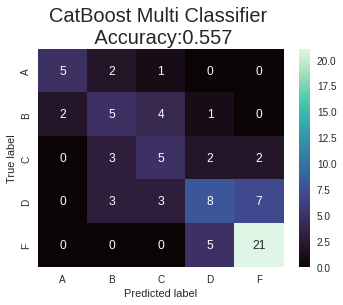

In [120]:
cm = confusion_matrix(test_target, preds)


cm_df = pd.DataFrame(cm,
                     index = ['A','B','C','D','F'],
                     columns = ['A','B','C','D','F'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True, cmap='mako')
plt.title('CatBoost Multi Classifier \n Accuracy:{0:.3f}'.format(accuracy_score(test_target, preds)), fontsize=20)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [121]:
pd.DataFrame(preds).value_counts()

F    30
D    16
C    13
B    13
A     7
dtype: int64

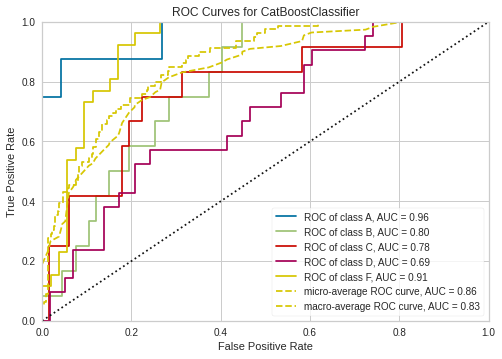

In [122]:
yellowbrick_model = wrap(best_model)
visualizer = ROCAUC(yellowbrick_model)
visualizer.fit(train_features, train_target)
visualizer.score(test_features, test_target)
visualizer.show()